# Import

In [1]:
# Misc
import os
import json
import joblib
import warnings
from ipywidgets import IntProgress
from IPython.display import display

# Data management
import numpy as np
import pandas as pd

# Sound treatments
import librosa
import soundfile as sf
from scipy import signal

# Data generator
from tensorflow.keras.utils import Sequence

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as pimnv2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as piv3
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import preprocess_input as penb0
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as prn50

# VGGish
from vggish import vggish_input
from vggish import vggish_params as params
import vggish_keras as vgk

# TRILL
import tensorflow.compat.v2 as tf2
tf2.enable_v2_behavior()
assert tf2.executing_eagerly()
import tensorflow_hub as hub

# Metrics
import tensorflow_addons as tfa
from tensorflow_addons.layers.netvlad import NetVLAD

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Environment

In [2]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Disable SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Display Tensorlfow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.config.list_physical_devices('GPU'):
    print('No GPU found. Please ensure you have installed TensorFlow correctly')

else:
    print('Default GPU Device: {}'.format(
        tf.config.list_physical_devices('GPU')))

    # Allow memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

TensorFlow Version: 2.6.0
Default GPU Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DATA_PATH = './data/'
WORKING_PATH = './working/final/'

# Data exploration

## Data load

In [4]:
# Load meta data
train_meta = pd.read_csv(DATA_PATH + 'train_metadata.csv',
                         sep=',', decimal='.', encoding='utf8', low_memory=False)

In [5]:
train_meta.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [6]:
# Load scored birds
with open(DATA_PATH + 'scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

scored_birds

['akiapo',
 'aniani',
 'apapan',
 'barpet',
 'crehon',
 'elepai',
 'ercfra',
 'hawama',
 'hawcre',
 'hawgoo',
 'hawhaw',
 'hawpet1',
 'houfin',
 'iiwi',
 'jabwar',
 'maupar',
 'omao',
 'puaioh',
 'skylar',
 'warwhe1',
 'yefcan']

## Distribution per class

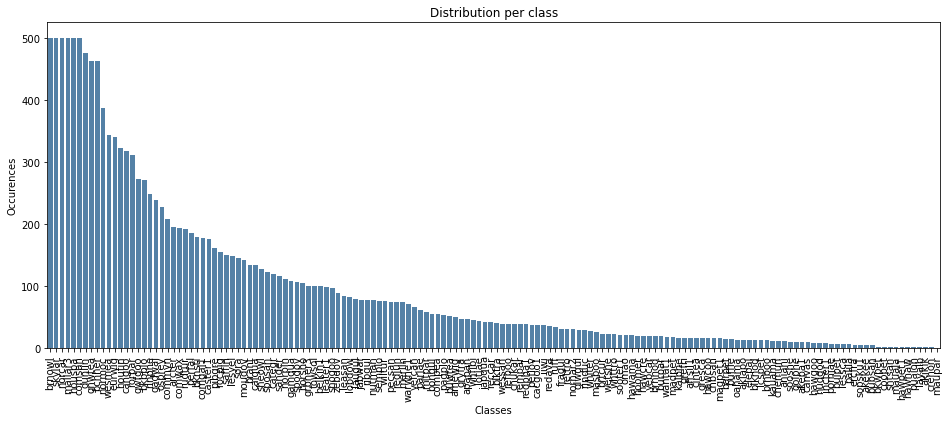

In [7]:
birds = train_meta["primary_label"].value_counts().to_dict()

fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(birds.keys()), y=list(birds.values()), color='steelblue')
plt.title('Distribution per class')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.show()

In [8]:
key_max = max(birds.keys(), key=(lambda k: birds[k]))
key_min = min(birds.keys(), key=(lambda k: birds[k]))

print('Number of classes: ', len(birds.keys()))
print('')
print('Minimum number of sounds for the class: ',
      key_min + ' ' + str(birds[key_min]))
print('Maximum number of sounds for the class: ',
      key_max + ' ' + str(birds[key_max]))
print('Total number of sounds: ', sum(birds.values()))
print('Average number of sounds per classes: ',
      sum(birds.values()) / len(birds.values()))

Number of classes:  152

Minimum number of sounds for the class:  maupar 1
Maximum number of sounds for the class:  brnowl 500
Total number of sounds:  14852
Average number of sounds per classes:  97.71052631578948


## Focus on scored birds

In [9]:
# Focus on 21 scored classes
data_filtered = train_meta[train_meta['primary_label'].isin(scored_birds)]

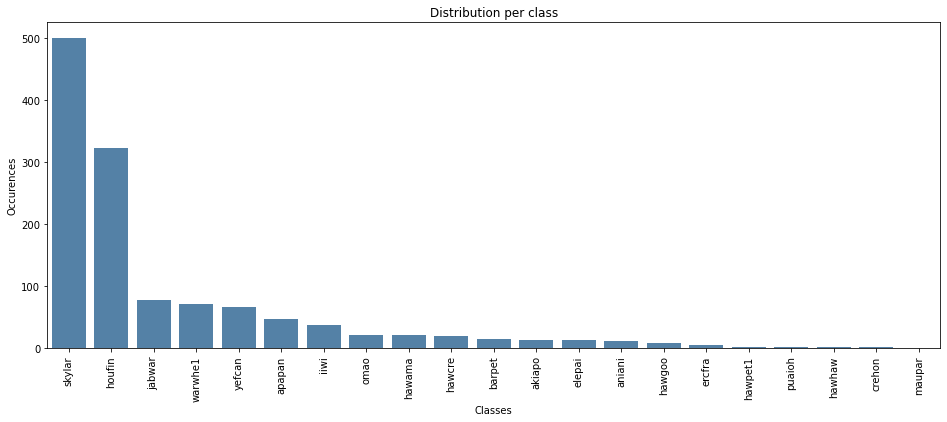

In [10]:
birds_filtered = data_filtered['primary_label'].value_counts().to_dict()

fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(birds_filtered.keys()), y=list(
    birds_filtered.values()), color='steelblue')
plt.title('Distribution per class')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.show()

In [11]:
key_max = max(birds_filtered.keys(), key=(lambda k: birds_filtered[k]))
key_min = min(birds_filtered.keys(), key=(lambda k: birds_filtered[k]))

print('Number of classes: ', len(birds_filtered.keys()))
print('Missing classes: ', scored_birds-birds_filtered.keys())
print('')
print('Minimum number of sounds for the class: ',
      key_min + ' ' + str(birds_filtered[key_min]))
print('Maximum number of sounds for the class: ',
      key_max + ' ' + str(birds_filtered[key_max]))
print('Total number of sounds: ', sum(birds_filtered.values()))
print('Average number of sounds per classes: ', sum(
    birds_filtered.values()) / len(birds_filtered.values()))

Number of classes:  21
Missing classes:  set()

Minimum number of sounds for the class:  maupar 1
Maximum number of sounds for the class:  skylar 500
Total number of sounds:  1266
Average number of sounds per classes:  60.285714285714285


## Birds number per sound

In [12]:
# Split secondary_labels in a list of birds
def split_secondary(df):
    record = df['secondary_labels'].replace(
        '[', '').replace(']', '').replace("'", "").split(',')
    return record


data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)

In [13]:
# Count the birds in the birds lists
def birds_number(df):
    return len(df['secondary_list'])


data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)

In [14]:
data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)
data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)

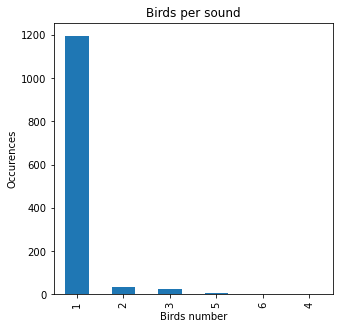

In [15]:
fig = plt.figure(figsize=(5, 5))
data_filtered['birds_number'].value_counts().plot(kind='bar')
plt.title('Birds per sound')
plt.xlabel('Birds number')
plt.ylabel('Occurences')
plt.show()

In [16]:
data_filtered['birds_number'].value_counts()

1    1197
2      35
3      23
5       5
6       3
4       3
Name: birds_number, dtype: int64

## Misc

In [17]:
data_filtered['primary_label'].value_counts()

skylar     500
houfin     322
jabwar      78
warwhe1     71
yefcan      67
apapan      47
iiwi        37
omao        21
hawama      21
hawcre      20
barpet      15
akiapo      14
elepai      14
aniani      12
hawgoo       9
ercfra       6
hawpet1      3
puaioh       3
hawhaw       3
crehon       2
maupar       1
Name: primary_label, dtype: int64

In [18]:
data_filtered.shape

(1266, 15)

## Sounds characteristics

In [19]:
if not os.path.exists(WORKING_PATH + 'sample_rates.jl'):
    # Instantiate the progress bar
    max_count = data_filtered.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    sample_rates = {}
    durations = []

    for index, row in data_filtered.iterrows():
        # Increment the progress bar
        f.value += 1

        # Load sound
        file_path = DATA_PATH + 'train_audio/' + row['filename']
        audio, sr = librosa.load(file_path)

        # Calculate duration
        duration = len(audio)/sr

        # Store
        if sr in sample_rates.keys():
            sample_rates[sr] += 1
        else:
            sample_rates[sr] = 1

        durations.append(duration)

    # Save
    joblib.dump(sample_rates, WORKING_PATH + 'sample_rates.jl')
    joblib.dump(durations, WORKING_PATH + 'durations.jl')

else:
    sample_rates = joblib.load(WORKING_PATH + 'sample_rates.jl')
    durations = joblib.load(WORKING_PATH + 'durations.jl')

In [20]:
print('Audios sample rates:', sample_rates)

Audios sample rates: {22050: 1266}


In [21]:
durations = np.array(durations)
print('Audios minimum duration:', np.min(durations))
print('Audios maximum duration:', np.max(durations))
print('Audios average duration:', np.mean(durations))

Audios minimum duration: 1.1160090702947847
Audios maximum duration: 996.9840362811791
Audios average duration: 53.04552557199815


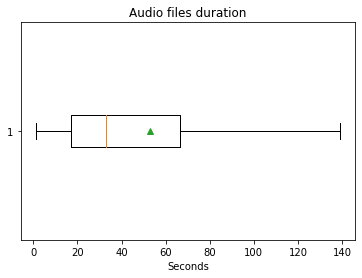

In [22]:
plt.boxplot(durations, vert=False, showmeans=True, showfliers=False)
plt.title('Audio files duration')
plt.xlabel('Seconds')
plt.show()

In [23]:
np.quantile(durations, 0.75, axis=0)

66.32963718820862

In [24]:
np.mean(durations)

53.04552557199815

## Conclusion

- 1266 audio files available for 21 classes
- Imbalanced data
- Most of the time, a sound contains 1 classe but sometimes more (multilabel)
- Sample rate 22050
- Sounds average duration is 50.42 seconds

# Baseline

- My baseline comes from the Kaggle kernel

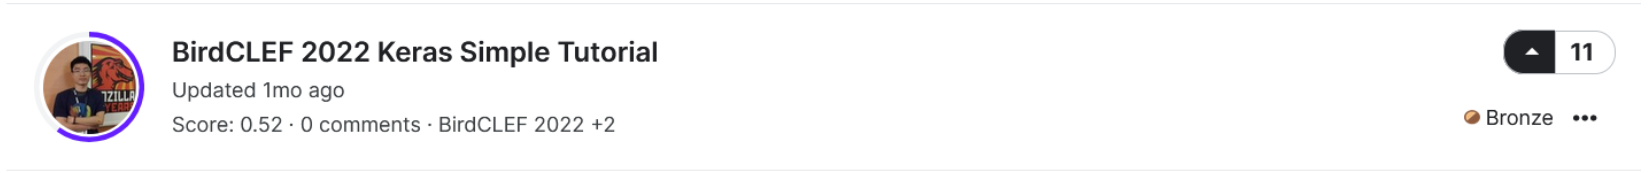

https://www.kaggle.com/code/duythanhng/birdclef-2022-keras-simple-tutorial

- It implements MFCC features extraction + MobileNetV2 for a multiclass classification 
- It has been trained with the 152 classes available
- It obtained a Kaggle submission score of 0.52

##### Modifications

- Adapt script to PEP8 standard
- Correction of cutAudio function for the last chunk to have the same lenght than others
- Load extracted features to RAM to speed up the training process
- Change learning rate strategy (Monitor val_loss instead of val_f1macro, ReduceLROnPlateau: factor=0.9)
- Focus only on 21 scored classes for training
- Switch to multi label classification (activation: softmax to sigmoid, loss: categorical_crossentropy to binary_crossentropy)
- Data normalization using MobileNetV2 preprocess_input functions
- Set up from 1 to 3 channels

## Split or load

In [25]:
def cutAudio(seconds, file_path, is_save):
    # First load the file
    filename = file_path.replace('/', '_')
    file_path = DATA_PATH + 'train_audio/' + file_path
    audio, sr = librosa.load(file_path)

    # Get number of samples for x seconds
    buffer = seconds * sr
    block_min = seconds * sr

    samples_total = len(audio)
    samples_wrote = 0
    counter = 1

    audio_split = []
    audio_filenames = []

    while samples_wrote < samples_total:
        # check if the buffer is not exceeding total samples
        if buffer > (samples_total - samples_wrote):
            buffer = samples_total - samples_wrote

        block = audio[samples_wrote: (samples_wrote + buffer)]

        # check if last block is as long as previous ones
        if block.shape[0] < (block_min):
            listofzeros = np.array([0] * (block_min - block.shape[0]))
            block = np.hstack([block, listofzeros])

        audio_split.append(block)

        # Write segment
        if is_save == True:
            out_filename = WORKING_PATH + 'each' + str(seconds) + 's/split_' + \
                str(counter) + '_' + filename
            audio_filenames.append(out_filename)
            sf.write(out_filename, block, sr)

        counter += 1
        samples_wrote += buffer

    return audio_split, sr, audio_filenames

In [26]:
def splitTrainAudio(seconds, _df):
    # Instantiate the progress bar
    max_count = _df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    data = []
    for index, row in _df.iterrows():
        # Increment the progress bar
        f.value += 1

        audio_lst, sr, filenames = cutAudio(seconds, row['filename'], True)

        for idx, y in enumerate(audio_lst):
            data.append(
                [row['primary_label'], row['secondary_labels'], row['filename'], filenames[idx]])

    data_df = pd.DataFrame(
        data, columns=['primary_label', 'secondary_labels', 'original_filename', 'filename'])
    data_df.to_csv(WORKING_PATH + 'data_' +
                   str(seconds) + '_df.csv', index=False)

In [27]:
if len(os.listdir(WORKING_PATH + 'each5s/')) == 0:
    # If not already done, split audio into 5 seconds chunks

    # Split audio
    splitTrainAudio(5, data_filtered)

    # Load split result
    data_df = pd.read_csv(WORKING_PATH + 'data_5_df.csv')

else:
    # If split done, load split result
    data_df = pd.read_csv(WORKING_PATH + 'data_5_df.csv')

## Create target

In [28]:
def to_list(df):
    temp = []
    primary_label = df['primary_label']

    if df['secondary_labels'] != '[]':
        secondary_labels = df['secondary_labels'].replace(
            '[', '').replace(']', '').replace("'", '').replace(' ', '').split(',')
    else:
        secondary_labels = None

    temp.append(primary_label)

    if secondary_labels != None:
        for item in secondary_labels:
            if item in scored_birds:
                if item not in temp:
                    temp.append(item)

    return tuple(temp)

In [29]:
# Create target
data_df['target'] = data_df.apply(to_list, axis=1)
data_df.to_pickle(WORKING_PATH + 'data.pkl')
data_df = pd.read_pickle(WORKING_PATH + 'data.pkl')
data_df

,primary_label,secondary_labels,original_filename,filename,target
0,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_1_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
1,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_2_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
2,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_3_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
3,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_4_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
4,akiapo,"['apapan', 'hawama', 'iiwi']",akiapo/XC122399.ogg,./working/final/each5s/split_5_akiapo_XC122399...,"(akiapo, apapan, hawama, iiwi)"
...,...,...,...,...,...
14075,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_3_yefcan_XC667142...,"(yefcan,)"
14076,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_4_yefcan_XC667142...,"(yefcan,)"
14077,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_5_yefcan_XC667142...,"(yefcan,)"
14078,yefcan,[],yefcan/XC667142.ogg,./working/final/each5s/split_6_yefcan_XC667142...,"(yefcan,)"


## MultiLabelBinarizer

In [30]:
# Fit a MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(data_df['target'].values.tolist())
mlb.classes_

array(['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai',
       'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1',
       'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar',
       'warwhe1', 'yefcan'], dtype=object)

## Data generator

In [31]:
class DataGenerator(Sequence):
    def __init__(self,
                 _X,
                 batch_size=32,
                 n_channels=1,
                 n_columns=470,
                 n_rows=120,
                 shuffle=True):
        self.batch_size = batch_size
        self.X = _X
        self.n_channels = n_channels
        self.n_columns = n_columns
        self.n_rows = n_rows
        self.shuffle = shuffle
        self.img_indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temps)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temps):
        X = np.empty((self.batch_size, self.n_rows,
                     self.n_columns, self.n_channels))
        y = np.empty((self.batch_size, len(mlb.classes_)), dtype=int)
        for i, ID in enumerate(list_IDs_temps):
            file_path = self.X.iloc[ID]['filename']

            #audio, sr = librosa.load(file_path)
            #feat = extractFeatures(audio, sr)

            feat = data_mem[file_path]

            #x_features = feat.tolist()
            #X[i] = np.array(x_features)
            X[i] = feat

            label = self.X.iloc[ID]['target']
            y[i] = mlb.transform([label])

        return X, y

In [32]:
data_mem = {}


def LoadRAM():
    # Load extracted features into RAM
    data_mem.clear()

    # Instantiate the progress bar
    max_count = data_df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    temp = {}

    for index, row in data_df.iterrows():
        # Increment the progress bar
        f.value += 1

        # Get file path
        file_path = row['filename']
        # Load audio file
        audio, sr = librosa.load(file_path)
        # Extracxt features
        feat = extractFeatures(audio, sr)

        # Store features into the dedicated dictionary
        temp[row['filename']] = feat

    return temp

## Preprocessing

In [33]:
def extractFeatures(y, sr):
    # Extract mfcc
    feat = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=conf.num_rows, n_mels=conf.n_mels)
    # Feed columns with 0 if number of columns < conf.num_columns
    if feat.shape[1] <= conf.num_columns:
        pad_width = conf.num_columns - feat.shape[1]
        feat = np.pad(feat, pad_width=(
            (0, 0), (0, pad_width)), mode='constant')
    # 3 channels
    feat = np.stack([feat, feat, feat], axis=-1)
    # preprocess
    feat = pimnv2(feat)

    X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
    x_features = feat.tolist()
    X[0] = np.array(x_features)

    return X

## Model

In [34]:
def create_cnn(model_name,
               fine_tune_at=None,
               model_path=None
               ):

    # Instanciate model
    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(include_top=False, input_shape=(
            conf.num_rows, conf.num_columns, conf.num_channels), weights='imagenet', pooling='avg')

    outputs = Dense(len(mlb.classes_), activation='sigmoid')(base_model.output)

    base_model.trainable = False

    model = Model(inputs=base_model.input, outputs=outputs)

    if fine_tune_at != None:
        # Load existing weights
        model.load_weights(model_path)

        # Unfreeze model layers
        model.trainable = True

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = False

    return model

## Training

In [35]:
def plot_his(history):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['f1macro'])
    plt.plot(history.history['val_f1macro'])
    plt.title('model f1macro')
    plt.ylabel('f1macro')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()

In [36]:
class conf:
    # Preprocessing settings
    n_mels = 224

    # Model parameters
    num_rows = 224
    num_columns = 224
    num_channels = 3

In [37]:
params = dict(
    batch_size=32,
    n_rows=conf.num_rows,
    n_columns=conf.num_columns,
    n_channels=conf.num_channels,
)
params_train = dict(
    shuffle=True,
    **params
)
params_valid = dict(
    shuffle=False,
    **params
)

In [38]:
def train_model(session_prefix,
                model_name,
                train_gen,
                val_gen,
                test_gen,
                fine_tune_at,
                model_path,
                learning_rate,
                epochs):

    # Define checkpoint_model_path
    checkpoint_model_path = WORKING_PATH + session_prefix + model_name + '.h5'

    num_epochs = epochs
    metric = 'val_loss'

    # Callbacks
    checkpointer = ModelCheckpoint(filepath=checkpoint_model_path,
                                   monitor=metric,
                                   mode='min',
                                   verbose=1,
                                   save_best_only=True)

    es_callback = EarlyStopping(monitor=metric,
                                mode='min',
                                patience=5,
                                verbose=1,
                                restore_best_weights=True
                                )

    reduce_lr = ReduceLROnPlateau(monitor=metric,
                                  factor=0.9,
                                  mode='min',
                                  patience=1,
                                  verbose=1,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=0.00001)

    # Model
    model = create_cnn(model_name, fine_tune_at, model_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(mlb.classes_), average='macro')])

    # Fit
    history = model.fit(
        train_gen,
        epochs=num_epochs,
        validation_data=val_gen,
        callbacks=[checkpointer, es_callback, reduce_lr],
        verbose=1
    )

    # Graph
    plot_his(history)

    # Scoring
    evaluation = model.evaluate_generator(test_gen)
    print('Scoring on test set:', evaluation)

In [37]:
# Load data in RAM to speed up training process
data_mem = LoadRAM()

IntProgress(value=0, max=14080)

In [39]:
# Split data
X_train, X_test, _, _ = train_test_split(
    data_df, data_df['target'], test_size=0.1, random_state=42)
X_train, X_valid, _, _ = train_test_split(
    X_train, X_train['target'], test_size=0.2, random_state=42)

# Instanciate data generators
train_generator = DataGenerator(X_train, **params_train)
valid_generator = DataGenerator(X_valid, **params_valid)
test_generator = DataGenerator(X_test, **params_valid)

Epoch 1/50
316/316 [==============================] - 16s 36ms/step - loss: 0.1605 - f1macro: 0.0629 - val_loss: 0.1442 - val_f1macro: 0.0740

Epoch 00001: val_loss improved from inf to 0.14422, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 34ms/step - loss: 0.1357 - f1macro: 0.1014 - val_loss: 0.1331 - val_f1macro: 0.1222

Epoch 00002: val_loss improved from 0.14422 to 0.13308, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
316/316 [==============================] - 11s 34ms/step - loss: 0.1272 - f1macro: 0.1325 - val_loss: 0.1253 - val_f1macro: 0.1378

Epoch 00003: val_loss improved from 0.13308 to 0.12534, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 4/50
316/316 [==============================] - 11s 34ms/step - loss: 0.1218 - f1macro: 0.1492 - val_loss: 0.1222 - val_f1macro: 0.1688

Epoch 00004: val_loss improved from 0.12534 to 0.12222, saving model to ./working/final\baseline

316/316 [==============================] - 11s 34ms/step - loss: 0.0917 - f1macro: 0.4779 - val_loss: 0.1035 - val_f1macro: 0.3161

Epoch 00032: val_loss improved from 0.10348 to 0.10347, saving model to ./working/final\baseline_MobileNetV2.h5

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.
Epoch 33/50
316/316 [==============================] - 11s 34ms/step - loss: 0.0914 - f1macro: 0.4799 - val_loss: 0.1033 - val_f1macro: 0.3399

Epoch 00033: val_loss improved from 0.10347 to 0.10326, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 34/50
316/316 [==============================] - 11s 34ms/step - loss: 0.0912 - f1macro: 0.4831 - val_loss: 0.1036 - val_f1macro: 0.3186

Epoch 00034: val_loss did not improve from 0.10326

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
Epoch 35/50
316/316 [==============================] - 11s 34ms/step - loss: 0.0909 - f1macro: 0.4890 - val_loss: 0.1031 - val_f1macro: 0.3342

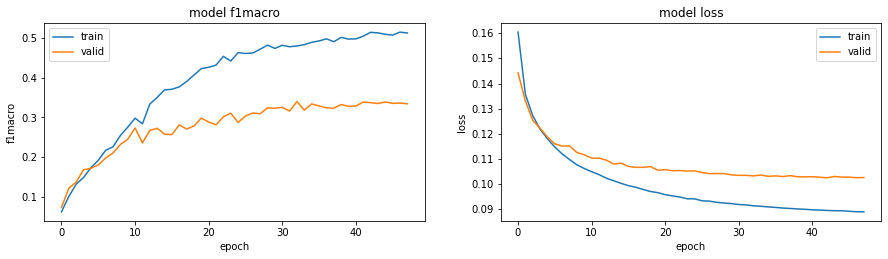

Scoring on test set: [0.10393772274255753, 0.3079107701778412]


In [39]:
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50)

## Conclusion

- Score on test set
    - F1 macro: 0.3079
    - Loss: 0.1039

# Class weight corrections

- Test different imbalanced data correction methods

## Class weight function

In [40]:
def class_weight(method, generator, mu=0.15):
    weights = {}

    if method == 'simple':
        labels_dict = {}
        count_class = 0
        for item in mlb.classes_:
            labels_dict[count_class] = 0

            for index, row in generator.X.iterrows():
                if item in row['target']:
                    labels_dict[count_class] += 1

            count_class += 1
            
        max_key = max(labels_dict, key=labels_dict.get)
        max_val = float(labels_dict[max_key])

        for i in sorted(labels_dict):
            weights[i] = float(max_val / labels_dict[i])

    elif method == 'log':
        labels_dict = {}
        count_class = 0
        for item in mlb.classes_:
            labels_dict[count_class] = 0

            for index, row in generator.X.iterrows():
                if item in row['target']:
                    labels_dict[count_class] += 1

            count_class += 1

        total = sum(labels_dict.values())
        keys = labels_dict.keys()

        for i in sorted(keys):
            score = np.log(mu*total/float(labels_dict[i]))
            weights[i] = score if score > 1 else 1

    else:
        return None

    return weights

## Adapt train_model function

In [41]:
def train_model(session_prefix,
                model_name,
                train_gen,
                val_gen,
                test_gen,
                fine_tune_at,
                model_path,
                learning_rate,
                epochs,
                cw_method,
                mu
               ):

    # Define checkpoint_model_path
    checkpoint_model_path = WORKING_PATH + session_prefix + model_name + '.h5'

    num_epochs = epochs
    metric = 'val_loss'

    # Callbacks
    checkpointer = ModelCheckpoint(filepath=checkpoint_model_path,
                                   monitor=metric,
                                   mode='min',
                                   verbose=1,
                                   save_best_only=True)

    es_callback = EarlyStopping(monitor=metric,
                                mode='min',
                                patience=5,
                                verbose=1,
                                restore_best_weights=True
                                )

    reduce_lr = ReduceLROnPlateau(monitor=metric,
                                  factor=0.9,
                                  mode='min',
                                  patience=1,
                                  verbose=1,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=0.00001)
    
    # Class weights
    class_weights = class_weight(method=cw_method, generator=train_gen, mu=mu)
    print('Class weights')
    print(class_weights)
    print('')

    # Model
    model = create_cnn(model_name, fine_tune_at, model_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(mlb.classes_), average='macro')])

    # Fit
    history = model.fit(
        train_gen,
        epochs=num_epochs,
        validation_data=val_gen,
        callbacks=[checkpointer, es_callback, reduce_lr],
        verbose=1,
        class_weight=class_weights
    )

    # Graph
    plot_his(history)

    # Scoring
    evaluation = model.evaluate_generator(test_gen)
    print('Scoring on test set:', evaluation)

## Simple method

Class weights
{0: 30.050359712230215, 1: 50.9390243902439, 2: 3.7596759675967597, 3: 28.222972972972972, 4: 245.7058823529412, 5: 24.570588235294117, 6: 321.3076923076923, 7: 6.9966499162479066, 8: 11.412568306010929, 9: 99.45238095238095, 10: 101.8780487804878, 11: 189.86363636363637, 12: 1.5614953271028038, 13: 4.595159515951595, 14: 6.124633431085044, 15: 122.8529411764706, 16: 8.944325481798716, 17: 464.1111111111111, 18: 1.0, 19: 5.09390243902439, 20: 11.934285714285714}

Epoch 1/50
316/316 [==============================] - 14s 37ms/step - loss: 1.2408 - f1macro: 0.0872 - val_loss: 0.1854 - val_f1macro: 0.1106

Epoch 00001: val_loss improved from inf to 0.18544, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 35ms/step - loss: 1.0509 - f1macro: 0.1314 - val_loss: 0.1778 - val_f1macro: 0.1291

Epoch 00002: val_loss improved from 0.18544 to 0.17775, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
3

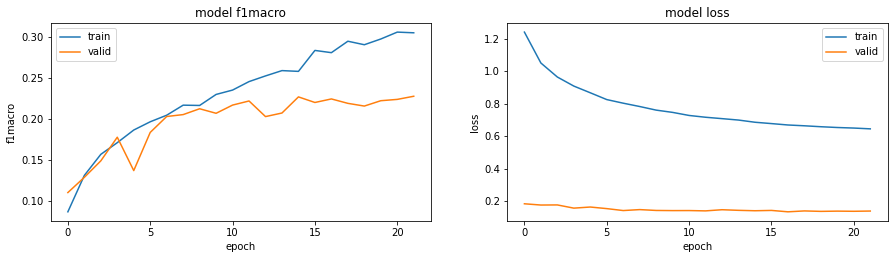

Scoring on test set: [0.1378670185804367, 0.24533288180828094]


In [42]:
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='simple',
            mu=None
            )

## Log method

Class weights
{0: 1, 1: 1, 2: 1, 3: 1, 4: 2.0243484676050705, 5: 1, 6: 2.29261245419975, 7: 1, 8: 1, 9: 1.119892193377918, 10: 1.1439897449569787, 11: 1.7665193583029706, 12: 1, 13: 1, 14: 1, 15: 1.331201287045125, 16: 1, 17: 2.660337234325067, 18: 1, 19: 1, 20: 1}

Epoch 1/50
316/316 [==============================] - 14s 37ms/step - loss: 0.1595 - f1macro: 0.0591 - val_loss: 0.1421 - val_f1macro: 0.0818

Epoch 00001: val_loss improved from inf to 0.14215, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1363 - f1macro: 0.1040 - val_loss: 0.1319 - val_f1macro: 0.1031

Epoch 00002: val_loss improved from 0.14215 to 0.13187, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1279 - f1macro: 0.1358 - val_loss: 0.1247 - val_f1macro: 0.1403

Epoch 00003: val_loss improved from 0.13187 to 0.12473, saving model to ./working/fi

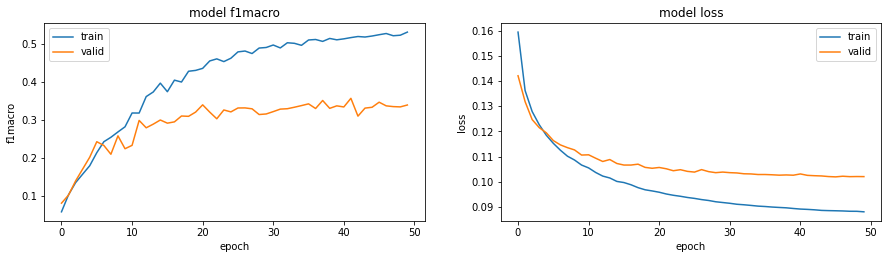

Scoring on test set: [0.10345409065485, 0.33696216344833374]


In [44]:
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.01
            )

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 14s 37ms/step - loss: 0.2370 - f1macro: 0.0773 - val_loss: 0.1471 - val_f1macro: 0.0930

Epoch 00001: val_loss improved from inf to 0.14708, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 35ms/step - loss: 0.2027 - f1macro: 0.1314 - val_loss: 0.1379 - val_f1macro: 0.1401

Epoch 00002: val_loss improved from 0.14708 to 0.13790, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
316/316 [============

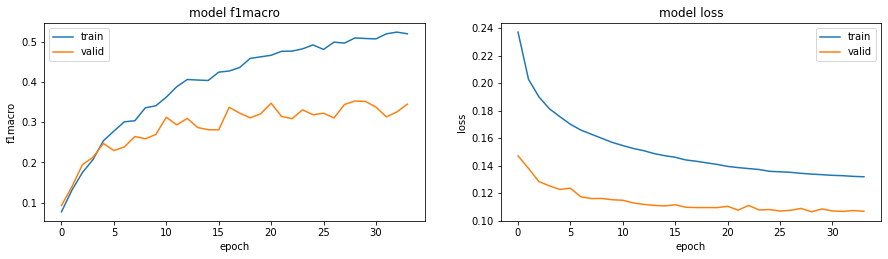

Scoring on test set: [0.10754677653312683, 0.3860054910182953]


In [45]:
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25
            )

Class weights
{0: 3.8351108839587407, 1: 4.362865569825179, 2: 1.7565690274498025, 3: 3.7723725433253175, 4: 5.936371473033216, 5: 3.6337863800391705, 6: 6.204635459627895, 7: 2.3776677036968303, 8: 2.8669514836880663, 9: 5.031915198806064, 10: 5.056012750385125, 11: 5.6785423637311165, 12: 1, 13: 1.9572397229119536, 14: 2.2445551592459703, 15: 5.243224292473271, 16: 2.623255559420535, 17: 6.572360239753213, 18: 1, 19: 2.060280476831134, 20: 2.911651662605973}

Epoch 1/50
316/316 [==============================] - 14s 37ms/step - loss: 0.2921 - f1macro: 0.0917 - val_loss: 0.1447 - val_f1macro: 0.1324

Epoch 00001: val_loss improved from inf to 0.14469, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 35ms/step - loss: 0.2534 - f1macro: 0.1401 - val_loss: 0.1372 - val_f1macro: 0.1697

Epoch 00002: val_loss improved from 0.14469 to 0.13724, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
316/316 [========

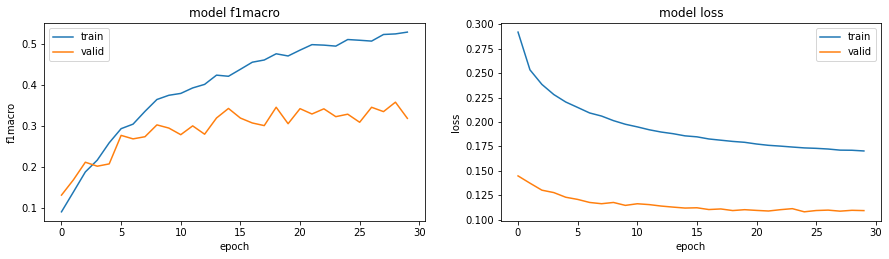

Scoring on test set: [0.10944559425115585, 0.3615730404853821]


In [46]:
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.50
            )

Class weights
{0: 3.54742881150696, 1: 4.0751834973733985, 2: 1.4688869549980215, 3: 3.4846904708735362, 4: 5.648689400581436, 5: 3.3461043075873897, 6: 5.916953387176115, 7: 2.0899856312450495, 8: 2.579269411236285, 9: 4.744233126354283, 10: 4.768330677933344, 11: 5.390860291279336, 12: 1, 13: 1.6695576504601726, 14: 1.9568730867941895, 15: 4.95554222002149, 16: 2.3355734869687543, 17: 6.284678167301432, 18: 1, 19: 1.7725984043793526, 20: 2.623969590154192}

Epoch 1/50
316/316 [==============================] - 14s 37ms/step - loss: 0.2738 - f1macro: 0.0863 - val_loss: 0.1538 - val_f1macro: 0.1132

Epoch 00001: val_loss improved from inf to 0.15385, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 35ms/step - loss: 0.2341 - f1macro: 0.1411 - val_loss: 0.1358 - val_f1macro: 0.1449

Epoch 00002: val_loss improved from 0.15385 to 0.13579, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
316/316 [==========

Epoch 30/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1552 - f1macro: 0.5203 - val_loss: 0.1079 - val_f1macro: 0.3485

Epoch 00030: val_loss did not improve from 0.10716

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
Epoch 31/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1547 - f1macro: 0.5202 - val_loss: 0.1073 - val_f1macro: 0.3610

Epoch 00031: val_loss did not improve from 0.10716

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
Epoch 32/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1543 - f1macro: 0.5250 - val_loss: 0.1075 - val_f1macro: 0.3523

Epoch 00032: val_loss did not improve from 0.10716

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00022876793809700757.
Epoch 33/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1540 - f1macro: 0.5319 - val_loss: 0.1072 - val_f1macro: 0.3558

Epoch 00033: val_loss did 

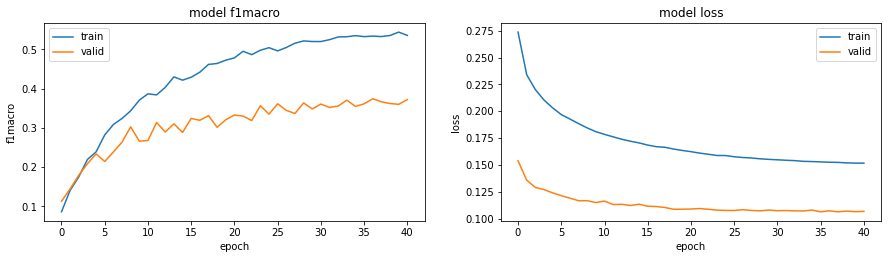

Scoring on test set: [0.10723264515399933, 0.33247289061546326]


In [49]:
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.375
            )

Class weights
{0: 2.44881652283885, 1: 2.976571208705289, 2: 1, 3: 2.3860781822054267, 4: 4.550077111913326, 5: 2.24749201891928, 6: 4.8183410985080055, 7: 1, 8: 1.4806571225681755, 9: 3.6456208376861734, 10: 3.669718389265234, 11: 4.292248002611226, 12: 1, 13: 1, 14: 1, 15: 3.8569299313533802, 16: 1.2369611983006445, 17: 5.186065878633323, 18: 1, 19: 1, 20: 1.5253573014860826}

Epoch 1/50
316/316 [==============================] - 14s 37ms/step - loss: 0.2018 - f1macro: 0.0714 - val_loss: 0.1441 - val_f1macro: 0.1049

Epoch 00001: val_loss improved from inf to 0.14414, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 36ms/step - loss: 0.1697 - f1macro: 0.1214 - val_loss: 0.1339 - val_f1macro: 0.1378

Epoch 00002: val_loss improved from 0.14414 to 0.13388, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
316/316 [==============================] - 11s 36ms/step - loss: 0.1590 - f1macro: 0.1660 - val_loss:


Epoch 00030: val_loss improved from 0.10488 to 0.10449, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 31/50
316/316 [==============================] - 11s 36ms/step - loss: 0.1102 - f1macro: 0.5081 - val_loss: 0.1044 - val_f1macro: 0.3060

Epoch 00031: val_loss improved from 0.10449 to 0.10443, saving model to ./working/final\baseline_MobileNetV2.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.
Epoch 32/50
316/316 [==============================] - 11s 36ms/step - loss: 0.1099 - f1macro: 0.5021 - val_loss: 0.1041 - val_f1macro: 0.3466

Epoch 00032: val_loss improved from 0.10443 to 0.10410, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 33/50
316/316 [==============================] - 11s 36ms/step - loss: 0.1095 - f1macro: 0.5134 - val_loss: 0.1050 - val_f1macro: 0.3290

Epoch 00033: val_loss did not improve from 0.10410

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
Epoch 34/50
316/3

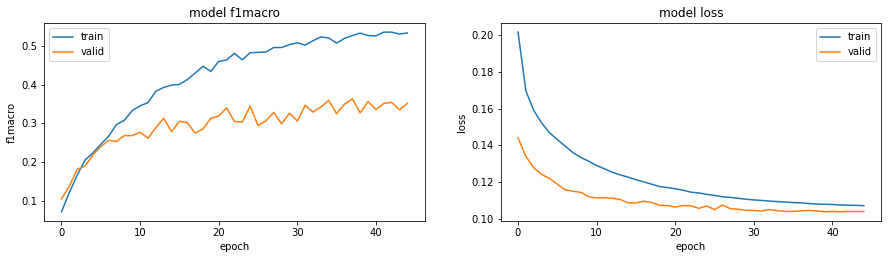

Scoring on test set: [0.10475670546293259, 0.33099183440208435]


In [50]:
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.125
            )

## Results

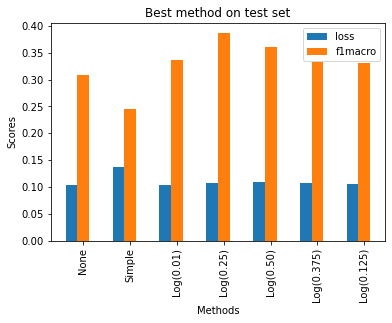

In [42]:
score = {}
loss = {}

score['None'] = 0.3079
score['Simple'] = 0.2453
score['Log(0.01)'] = 0.3369
score['Log(0.25)'] = 0.3860
score['Log(0.50)'] = 0.3615
score['Log(0.375)'] = 0.3324
score['Log(0.125)'] = 0.3309

loss['None'] = 0.1039
loss['Simple'] = 0.1378
loss['Log(0.01)'] = 0.1034
loss['Log(0.25)'] = 0.1075
loss['Log(0.50)'] = 0.1094
loss['Log(0.375)'] = 0.1072
loss['Log(0.125)'] = 0.1047

ind = np.arange(7)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Methods')
plt.ylabel('Scores')
plt.title('Best method on test set')

plt.xticks(ind + width, ['None', 'Simple', 'Log(0.01)', 'Log(0.25)',
           'Log(0.50)', 'Log(0.375)', 'Log(0.125)'], rotation=90)
plt.legend(loc='best')
plt.show()

# Test other models

## Update functions

In [42]:
def create_cnn(model_name,
               fine_tune_at=None,
               model_path=None,
               hidden=None
               ):

    # Instanciate model
    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(include_top=False, input_shape=(
            conf.num_rows, conf.num_columns, conf.num_channels), weights='imagenet', pooling='avg')
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(include_top=False, input_shape=(
            conf.num_rows, conf.num_columns, conf.num_channels), weights='imagenet', pooling='avg')
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(include_top=False, input_shape=(
            conf.num_rows, conf.num_columns, conf.num_channels), weights='imagenet', pooling='avg')
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, input_shape=(
            conf.num_rows, conf.num_columns, conf.num_channels), weights='imagenet', pooling='avg')

    if hidden == None:
        outputs = Dense(len(mlb.classes_), activation='sigmoid')(base_model.output)
    else:
        dense = Dense(hidden, activation='relu')(base_model.output)
        outputs = Dense(len(mlb.classes_), activation='sigmoid')(dense)

    base_model.trainable = False

    model = Model(inputs=base_model.input, outputs=outputs)

    if fine_tune_at != None:
        # Load existing weights
        model.load_weights(model_path)

        # Unfreeze model layers
        model.trainable = True

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = False

    return model

In [43]:
def train_model(session_prefix,
                model_name,
                train_gen,
                val_gen,
                test_gen,
                fine_tune_at,
                model_path,
                learning_rate,
                epochs,
                cw_method,
                mu,
                hidden
               ):

    # Define checkpoint_model_path
    checkpoint_model_path = WORKING_PATH + session_prefix + model_name + '.h5'

    num_epochs = epochs
    metric = 'val_loss'

    # Callbacks
    checkpointer = ModelCheckpoint(filepath=checkpoint_model_path,
                                   monitor=metric,
                                   mode='min',
                                   verbose=1,
                                   save_best_only=True)

    es_callback = EarlyStopping(monitor=metric,
                                mode='min',
                                patience=5,
                                verbose=1,
                                restore_best_weights=True
                                )

    reduce_lr = ReduceLROnPlateau(monitor=metric,
                                  factor=0.9,
                                  mode='min',
                                  patience=1,
                                  verbose=1,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=0.00001)
    
    # Class weights
    class_weights = class_weight(method=cw_method, generator=train_gen, mu=mu)
    print('Class weights')
    print(class_weights)
    print('')

    # Model
    model = create_cnn(model_name, fine_tune_at, model_path, hidden)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(mlb.classes_), average='macro')])

    # Fit
    history = model.fit(
        train_gen,
        epochs=num_epochs,
        validation_data=val_gen,
        callbacks=[checkpointer, es_callback, reduce_lr],
        verbose=1,
        class_weight=class_weights
    )

    # Graph
    plot_his(history)

    # Scoring
    evaluation = model.evaluate_generator(test_gen)
    print('Scoring on test set:', evaluation)

In [44]:
def extractFeatures(model_name, y, sr):
    # Extract mfcc
    feat = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=conf.num_rows, n_mels=conf.n_mels)
    # Feed columns with 0 if number of columns < conf.num_columns
    if feat.shape[1] <= conf.num_columns:
        pad_width = conf.num_columns - feat.shape[1]
        feat = np.pad(feat, pad_width=(
            (0, 0), (0, pad_width)), mode='constant')
    # 3 channels
    feat = np.stack([feat, feat, feat], axis=-1)
    # preprocess
    if model_name == 'MobileNetV2':
        feat = pimnv2(feat)
    elif model_name == 'InceptionV3':
        feat = piv3(feat)
    elif model_name == 'EfficientNetB0':
        feat = penb0(feat)
    elif model_name == 'ResNet50':
        feat = prn50(feat)

    X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
    x_features = feat.tolist()
    X[0] = np.array(x_features)

    return X

In [45]:
def LoadRAM(model_name):
    # Load extracted features into RAM
    data_mem.clear()

    # Instantiate the progress bar
    max_count = data_df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    temp = {}

    for index, row in data_df.iterrows():
        # Increment the progress bar
        f.value += 1

        # Get file path
        file_path = row['filename']
        # Load audio file
        audio, sr = librosa.load(file_path)
        # Extracxt features
        feat = extractFeatures(model_name, audio, sr)

        # Store features into the dedicated dictionary
        temp[row['filename']] = feat

    return temp

## MobileNetV2

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 14s 37ms/step - loss: 0.2250 - f1macro: 0.0982 - val_loss: 0.1409 - val_f1macro: 0.1284

Epoch 00001: val_loss improved from inf to 0.14093, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1901 - f1macro: 0.1672 - val_loss: 0.1275 - val_f1macro: 0.1924

Epoch 00002: val_loss improved from 0.14093 to 0.12750, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 3/50
316/316 [============

316/316 [==============================] - 11s 35ms/step - loss: 0.1022 - f1macro: 0.5349 - val_loss: 0.0978 - val_f1macro: 0.3604

Epoch 00030: val_loss did not improve from 0.09759

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00022876793809700757.
Epoch 31/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1010 - f1macro: 0.5355 - val_loss: 0.0973 - val_f1macro: 0.3641

Epoch 00031: val_loss improved from 0.09759 to 0.09735, saving model to ./working/final\baseline_MobileNetV2.h5
Epoch 32/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1007 - f1macro: 0.5336 - val_loss: 0.0981 - val_f1macro: 0.3625

Epoch 00032: val_loss did not improve from 0.09735

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00020589114428730683.
Epoch 33/50
316/316 [==============================] - 11s 35ms/step - loss: 0.0998 - f1macro: 0.5429 - val_loss: 0.0974 - val_f1macro: 0.3880

Epoch 00033: val_loss did not improve from 0.09735

Epoch 

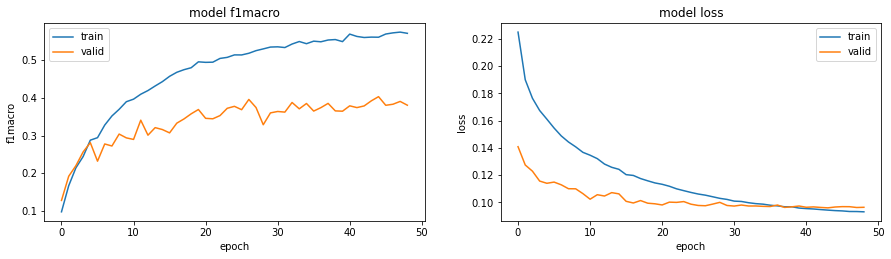

Scoring on test set: [0.0954984501004219, 0.41456714272499084]


In [56]:
# Add hidden layer
train_model(session_prefix='baseline_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

## InceptionV3

In [57]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('InceptionV3')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 22s 56ms/step - loss: 0.2227 - f1macro: 0.1392 - val_loss: 0.1387 - val_f1macro: 0.1968

Epoch 00001: val_loss improved from inf to 0.13867, saving model to ./working/final\baseline_InceptionV3.h5
Epoch 2/50
316/316 [==============================] - 17s 53ms/step - loss: 0.1861 - f1macro: 0.2365 - val_loss: 0.1334 - val_f1macro: 0.2200

Epoch 00002: val_loss improved from 0.13867 to 0.13336, saving model to ./working/final\baseline_InceptionV3.h5
Epoch 3/50
316/316 [============

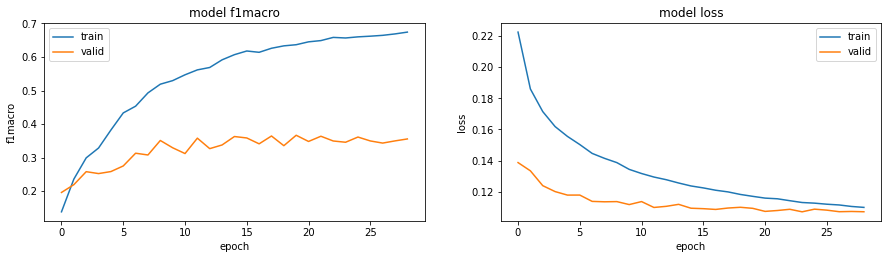

Scoring on test set: [0.10964855551719666, 0.38624051213264465]


In [58]:
train_model(session_prefix='baseline_',
            model_name='InceptionV3',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=None
            )

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 21s 57ms/step - loss: 0.2186 - f1macro: 0.1478 - val_loss: 0.1518 - val_f1macro: 0.1872

Epoch 00001: val_loss improved from inf to 0.15181, saving model to ./working/final\baseline_InceptionV3.h5
Epoch 2/50
316/316 [==============================] - 17s 53ms/step - loss: 0.1806 - f1macro: 0.2366 - val_loss: 0.1217 - val_f1macro: 0.2254

Epoch 00002: val_loss improved from 0.15181 to 0.12165, saving model to ./working/final\baseline_InceptionV3.h5
Epoch 3/50
316/316 [============

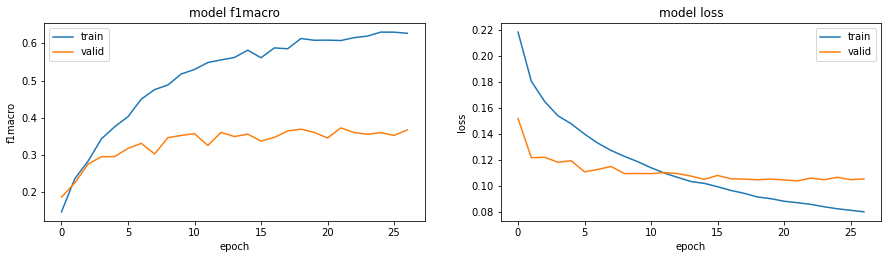

Scoring on test set: [0.10498079657554626, 0.37512850761413574]


In [59]:
# Add hidden layer
train_model(session_prefix='baseline_',
            model_name='InceptionV3',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

## EfficientNetB0

In [60]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('EfficientNetB0')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 22s 57ms/step - loss: 0.2472 - f1macro: 0.0524 - val_loss: 0.1564 - val_f1macro: 0.0641

Epoch 00001: val_loss improved from inf to 0.15637, saving model to ./working/final\baseline_EfficientNetB0.h5
Epoch 2/50
316/316 [==============================] - 17s 54ms/step - loss: 0.2182 - f1macro: 0.0868 - val_loss: 0.1471 - val_f1macro: 0.1117

Epoch 00002: val_loss improved from 0.15637 to 0.14714, saving model to ./working/final\baseline_EfficientNetB0.h5
Epoch 3/50
316/316 [======

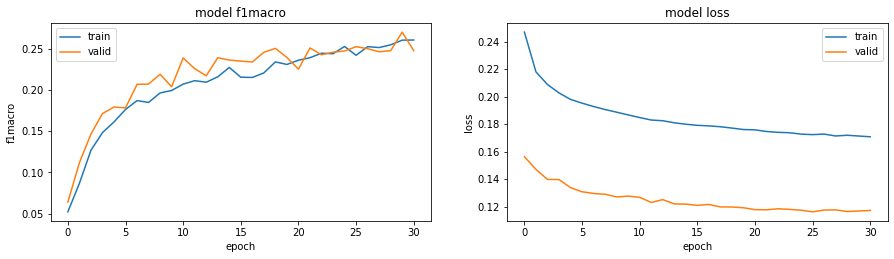

Scoring on test set: [0.1179056465625763, 0.2529705762863159]


In [61]:
train_model(session_prefix='baseline_',
            model_name='EfficientNetB0',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=None
            )

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 23s 57ms/step - loss: 0.2385 - f1macro: 0.0718 - val_loss: 0.1448 - val_f1macro: 0.1263

Epoch 00001: val_loss improved from inf to 0.14479, saving model to ./working/final\baseline_EfficientNetB0.h5
Epoch 2/50
316/316 [==============================] - 17s 55ms/step - loss: 0.2068 - f1macro: 0.1290 - val_loss: 0.1338 - val_f1macro: 0.1478

Epoch 00002: val_loss improved from 0.14479 to 0.13375, saving model to ./working/final\baseline_EfficientNetB0.h5
Epoch 3/50
316/316 [======

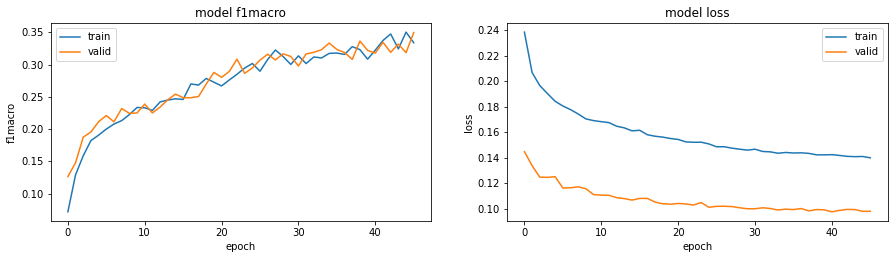

Scoring on test set: [0.09852960705757141, 0.3261714577674866]


In [62]:
# Add hidden layer
train_model(session_prefix='baseline_',
            model_name='EfficientNetB0',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

## ResNet50

In [63]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('ResNet50')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 28s 77ms/step - loss: 0.2429 - f1macro: 0.0759 - val_loss: 0.1552 - val_f1macro: 0.1108

Epoch 00001: val_loss improved from inf to 0.15524, saving model to ./working/final\baseline_ResNet50.h5
Epoch 2/50
316/316 [==============================] - 24s 75ms/step - loss: 0.2096 - f1macro: 0.1517 - val_loss: 0.1447 - val_f1macro: 0.1615

Epoch 00002: val_loss improved from 0.15524 to 0.14466, saving model to ./working/final\baseline_ResNet50.h5
Epoch 3/50
316/316 [==================

316/316 [==============================] - 24s 76ms/step - loss: 0.1358 - f1macro: 0.5125 - val_loss: 0.1068 - val_f1macro: 0.3359

Epoch 00031: val_loss did not improve from 0.10656

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.
Epoch 32/50
316/316 [==============================] - 24s 76ms/step - loss: 0.1352 - f1macro: 0.5206 - val_loss: 0.1087 - val_f1macro: 0.3709

Epoch 00032: val_loss did not improve from 0.10656

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
Epoch 33/50
316/316 [==============================] - 28s 88ms/step - loss: 0.1345 - f1macro: 0.5170 - val_loss: 0.1077 - val_f1macro: 0.3278

Epoch 00033: val_loss did not improve from 0.10656

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
Epoch 34/50
316/316 [==============================] - 49s 155ms/step - loss: 0.1342 - f1macro: 0.5184 - val_loss: 0.1068 - val_f1macro: 0.3412

Epoch 00034: val_loss did not improve

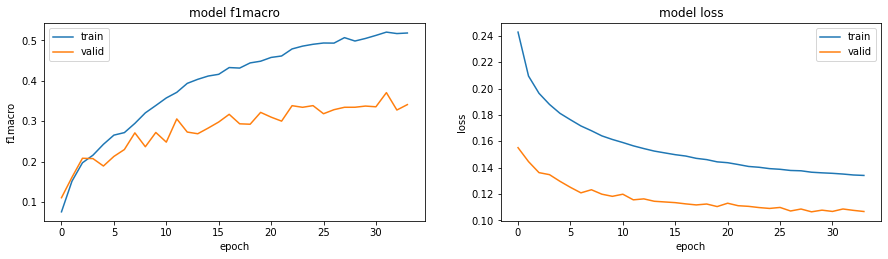

Scoring on test set: [0.10619663447141647, 0.40488970279693604]


In [64]:
train_model(session_prefix='baseline_',
            model_name='ResNet50',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=None
            )

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 49s 149ms/step - loss: 0.2420 - f1macro: 0.0880 - val_loss: 0.1499 - val_f1macro: 0.1047

Epoch 00001: val_loss improved from inf to 0.14993, saving model to ./working/final\baseline_ResNet50.h5
Epoch 2/50
316/316 [==============================] - 46s 147ms/step - loss: 0.2042 - f1macro: 0.1664 - val_loss: 0.1338 - val_f1macro: 0.1547

Epoch 00002: val_loss improved from 0.14993 to 0.13385, saving model to ./working/final\baseline_ResNet50.h5
Epoch 3/50
316/316 [================

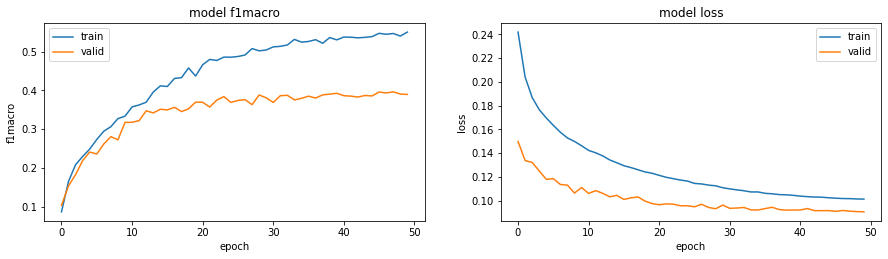

Scoring on test set: [0.09075365215539932, 0.42487674951553345]


In [65]:
# Add hidden layer
train_model(session_prefix='baseline_',
            model_name='ResNet50',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

## Results

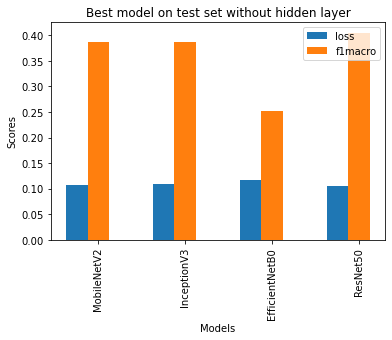

In [2]:
score = {}
loss = {}

score['MobileNetV2'] = 0.3860
score['InceptionV3'] = 0.3862
score['EfficientNetB0'] = 0.2529
score['ResNet50'] = 0.4048

loss['MobileNetV2'] = 0.1075
loss['InceptionV3'] = 0.1096
loss['EfficientNetB0'] = 0.1179
loss['ResNet50'] = 0.1061

ind = np.arange(4)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Best model on test set without hidden layer')

plt.xticks(ind + width, ['MobileNetV2', 'InceptionV3',
           'EfficientNetB0', 'ResNet50'], rotation=90)
plt.legend(loc='best')
plt.show()

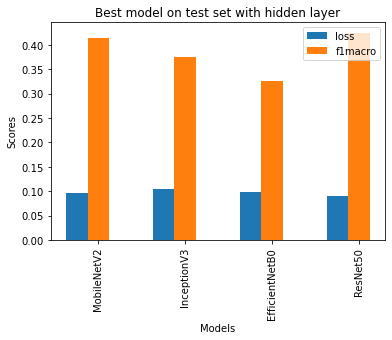

In [3]:
score = {}
loss = {}

score['MobileNetV2'] = 0.4145
score['InceptionV3'] = 0.3751
score['EfficientNetB0'] = 0.3261
score['ResNet50'] = 0.4248

loss['MobileNetV2'] = 0.0954
loss['InceptionV3'] = 0.1049
loss['EfficientNetB0'] = 0.0985
loss['ResNet50'] = 0.0907

ind = np.arange(4)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Best model on test set with hidden layer')

plt.xticks(ind + width, ['MobileNetV2', 'InceptionV3',
           'EfficientNetB0', 'ResNet50'], rotation=90)
plt.legend(loc='best')
plt.show()

# Test features extraction methods

## Sound noise reduction + mfcc

In [46]:
# Sound noise reduction
def f_high(y, sr):
    b, a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b, a, y)
    return yf

In [47]:
def extractFeatures(model_name, y, sr):
    # Sound noise reduction
    y = f_high(y, sr)
    
    # Extract mfcc
    feat = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=conf.num_rows, n_mels=conf.n_mels)
    # Feed columns with 0 if number of columns < conf.num_columns
    if feat.shape[1] <= conf.num_columns:
        pad_width = conf.num_columns - feat.shape[1]
        feat = np.pad(feat, pad_width=(
            (0, 0), (0, pad_width)), mode='constant')
        
    # 3 channels
    feat = np.stack([feat, feat, feat], axis=-1)
    
    # preprocess
    if model_name == 'MobileNetV2':
        feat = pimnv2(feat)
    elif model_name == 'InceptionV3':
        feat = piv3(feat)
    elif model_name == 'EfficientNetB0':
        feat = penb0(feat)
    elif model_name == 'ResNet50':
        feat = prn50(feat)

    X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
    x_features = feat.tolist()
    X[0] = np.array(x_features)

    return X

### MobileNetV2

In [69]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('MobileNetV2')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 16s 44ms/step - loss: 0.2360 - f1macro: 0.0699 - val_loss: 0.1451 - val_f1macro: 0.0953

Epoch 00001: val_loss improved from inf to 0.14508, saving model to ./working/final\baseline_snr_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 14s 43ms/step - loss: 0.2050 - f1macro: 0.1202 - val_loss: 0.1352 - val_f1macro: 0.1411

Epoch 00002: val_loss improved from 0.14508 to 0.13517, saving model to ./working/final\baseline_snr_MobileNetV2.h5
Epoch 3/50
316/316 [====

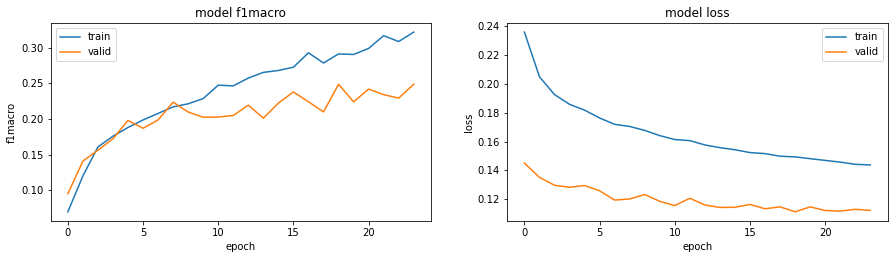

Scoring on test set: [0.11005937308073044, 0.21225449442863464]


In [70]:
train_model(session_prefix='baseline_snr_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### InceptionV3

In [71]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('InceptionV3')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 28s 78ms/step - loss: 0.2327 - f1macro: 0.0879 - val_loss: 0.1430 - val_f1macro: 0.0865

Epoch 00001: val_loss improved from inf to 0.14305, saving model to ./working/final\baseline_snr_InceptionV3.h5
Epoch 2/50
316/316 [==============================] - 24s 75ms/step - loss: 0.2030 - f1macro: 0.1474 - val_loss: 0.1351 - val_f1macro: 0.1154

Epoch 00002: val_loss improved from 0.14305 to 0.13506, saving model to ./working/final\baseline_snr_InceptionV3.h5
Epoch 3/50
316/316 [====

316/316 [==============================] - 24s 76ms/step - loss: 0.1308 - f1macro: 0.4159 - val_loss: 0.1154 - val_f1macro: 0.2682

Epoch 00030: val_loss did not improve from 0.11496

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
Epoch 31/50
316/316 [==============================] - 24s 76ms/step - loss: 0.1301 - f1macro: 0.4271 - val_loss: 0.1165 - val_f1macro: 0.2609

Epoch 00031: val_loss did not improve from 0.11496

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0001350851875031367.
Epoch 32/50
316/316 [==============================] - 24s 76ms/step - loss: 0.1295 - f1macro: 0.4306 - val_loss: 0.1147 - val_f1macro: 0.2795

Epoch 00032: val_loss improved from 0.11496 to 0.11471, saving model to ./working/final\baseline_snr_InceptionV3.h5
Epoch 33/50
316/316 [==============================] - 24s 76ms/step - loss: 0.1289 - f1macro: 0.4310 - val_loss: 0.1168 - val_f1macro: 0.2653

Epoch 00033: val_loss did not improve from 0.11471

Epo

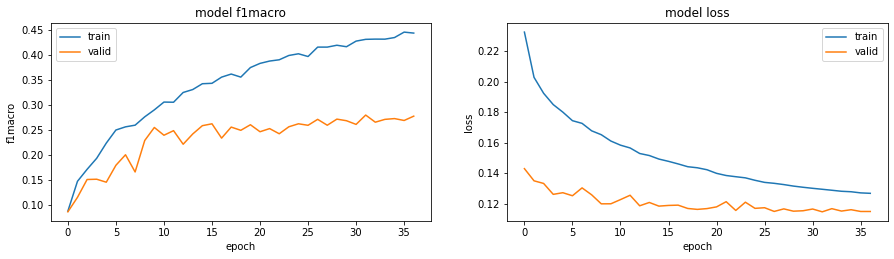

Scoring on test set: [0.11493168026208878, 0.206657275557518]


In [72]:
train_model(session_prefix='baseline_snr_',
            model_name='InceptionV3',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### EfficientNetB0

In [73]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('EfficientNetB0')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 27s 71ms/step - loss: 0.2506 - f1macro: 0.0481 - val_loss: 0.1564 - val_f1macro: 0.0562

Epoch 00001: val_loss improved from inf to 0.15645, saving model to ./working/final\baseline_snr_EfficientNetB0.h5
Epoch 2/50
316/316 [==============================] - 22s 69ms/step - loss: 0.2252 - f1macro: 0.0775 - val_loss: 0.1503 - val_f1macro: 0.1042

Epoch 00002: val_loss improved from 0.15645 to 0.15035, saving model to ./working/final\baseline_snr_EfficientNetB0.h5
Epoch 3/50
316/316

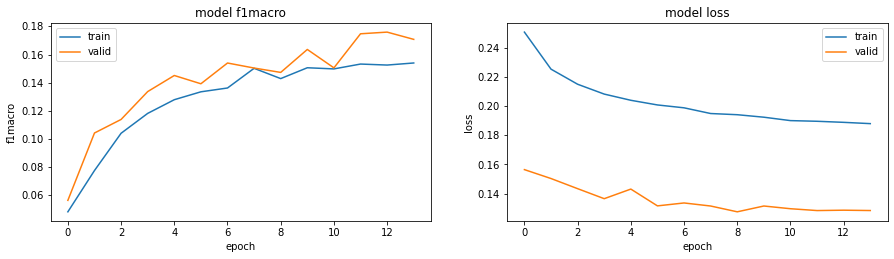

Scoring on test set: [0.12671127915382385, 0.12413720041513443]


In [74]:
train_model(session_prefix='baseline_snr_',
            model_name='EfficientNetB0',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### ResNet50

In [75]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('ResNet50')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 46s 138ms/step - loss: 0.2507 - f1macro: 0.0582 - val_loss: 0.1592 - val_f1macro: 0.0559

Epoch 00001: val_loss improved from inf to 0.15924, saving model to ./working/final\baseline_snr_ResNet50.h5
Epoch 2/50
316/316 [==============================] - 44s 140ms/step - loss: 0.2251 - f1macro: 0.0851 - val_loss: 0.1576 - val_f1macro: 0.0987

Epoch 00002: val_loss improved from 0.15924 to 0.15756, saving model to ./working/final\baseline_snr_ResNet50.h5
Epoch 3/50
316/316 [========


Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.00018530203378759326.
Epoch 30/50
316/316 [==============================] - 27s 85ms/step - loss: 0.1577 - f1macro: 0.2606 - val_loss: 0.1137 - val_f1macro: 0.2233

Epoch 00030: val_loss improved from 0.11422 to 0.11374, saving model to ./working/final\baseline_snr_ResNet50.h5
Epoch 31/50
316/316 [==============================] - 30s 96ms/step - loss: 0.1578 - f1macro: 0.2687 - val_loss: 0.1140 - val_f1macro: 0.2238

Epoch 00031: val_loss did not improve from 0.11374

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00016677183302817866.
Epoch 32/50
316/316 [==============================] - 24s 77ms/step - loss: 0.1571 - f1macro: 0.2633 - val_loss: 0.1145 - val_f1macro: 0.2273

Epoch 00032: val_loss did not improve from 0.11374

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
Epoch 33/50
316/316 [==============================] - 24s 76ms/step - loss: 0.1567 - f1macro: 0.2646 - val

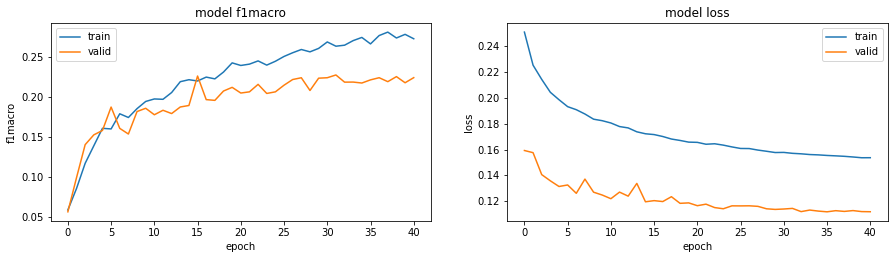

Scoring on test set: [0.11220584064722061, 0.24168972671031952]


In [76]:
train_model(session_prefix='baseline_snr_',
            model_name='ResNet50',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### Result

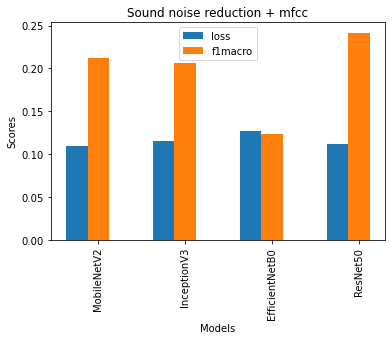

In [12]:
score = {}
loss = {}

score['MobileNetV2'] = 0.2122
score['InceptionV3'] = 0.2066
score['EfficientNetB0'] = 0.1241
score['ResNet50'] = 0.2416

loss['MobileNetV2'] = 0.1100
loss['InceptionV3'] = 0.1149
loss['EfficientNetB0'] = 0.1267
loss['ResNet50'] = 0.1122

ind = np.arange(4)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Sound noise reduction + mfcc')

plt.xticks(ind + width, ['MobileNetV2', 'InceptionV3',
           'EfficientNetB0', 'ResNet50'], rotation=90)
plt.legend(loc='best')
plt.show()

## Sound noise reduction + vocal separation

In [48]:
def vocalseparation(y, sr):
    # Compute the spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(y, n_fft=446, hop_length=494))
    
    # This suppresses sparse/non-repetetitive deviations from the average spectrum,
    # and works well to discard vocal elements.
    S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))
    
    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimium
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)

    # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
    # Note: the margins need not be equal for foreground and background separation
    margin_i, margin_v = 2, 10
    power = 2

    mask_i = librosa.util.softmask(S_filter,
                                   margin_i * (S_full - S_filter),
                                   power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                                   margin_v * S_filter,
                                   power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full   
    
    return S_foreground

In [49]:
def extractFeatures(model_name, y, sr):
    # Sound noise reduction
    y = f_high(y, sr)
    
    # Extract features
    feat = vocalseparation(y, sr)
    
    # Feed columns with 0 if number of columns < conf.num_columns
    if feat.shape[1] <= conf.num_columns:
        pad_width = conf.num_columns - feat.shape[1]
        feat = np.pad(feat, pad_width=(
            (0, 0), (0, pad_width)), mode='constant')
        
    # 3 channels
    feat = np.stack([feat, feat, feat], axis=-1)
    
    # preprocess
    if model_name == 'MobileNetV2':
        feat = pimnv2(feat)
    elif model_name == 'InceptionV3':
        feat = piv3(feat)
    elif model_name == 'EfficientNetB0':
        feat = penb0(feat)
    elif model_name == 'ResNet50':
        feat = prn50(feat)

    X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
    x_features = feat.tolist()
    X[0] = np.array(x_features)

    return X

### MobileNetV2

In [84]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('MobileNetV2')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 16s 44ms/step - loss: 0.2466 - f1macro: 0.0702 - val_loss: 0.1559 - val_f1macro: 0.0799

Epoch 00001: val_loss improved from inf to 0.15589, saving model to ./working/final\baseline_vs_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 14s 43ms/step - loss: 0.2222 - f1macro: 0.1084 - val_loss: 0.1554 - val_f1macro: 0.1223

Epoch 00002: val_loss improved from 0.15589 to 0.15538, saving model to ./working/final\baseline_vs_MobileNetV2.h5
Epoch 3/50
316/316 [======

316/316 [==============================] - 14s 44ms/step - loss: 0.1721 - f1macro: 0.2976 - val_loss: 0.1280 - val_f1macro: 0.1943

Epoch 00030: val_loss did not improve from 0.12756

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00016677183302817866.
Epoch 31/50
316/316 [==============================] - 14s 44ms/step - loss: 0.1716 - f1macro: 0.2946 - val_loss: 0.1273 - val_f1macro: 0.2323

Epoch 00031: val_loss improved from 0.12756 to 0.12732, saving model to ./working/final\baseline_vs_MobileNetV2.h5
Epoch 32/50
316/316 [==============================] - 14s 43ms/step - loss: 0.1713 - f1macro: 0.3008 - val_loss: 0.1279 - val_f1macro: 0.1966

Epoch 00032: val_loss did not improve from 0.12732

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
Epoch 33/50
316/316 [==============================] - 14s 43ms/step - loss: 0.1706 - f1macro: 0.2994 - val_loss: 0.1278 - val_f1macro: 0.2299

Epoch 00033: val_loss did not improve from 0.12732

Epo

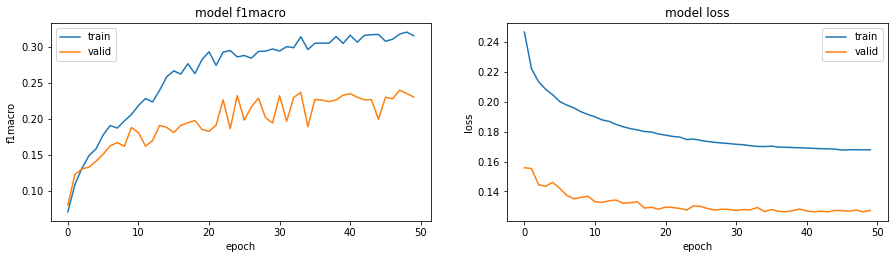

Scoring on test set: [0.1263173520565033, 0.1919645518064499]


In [85]:
train_model(session_prefix='baseline_vs_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### InceptionV3

In [86]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('InceptionV3')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 28s 77ms/step - loss: 0.2311 - f1macro: 0.1144 - val_loss: 0.1425 - val_f1macro: 0.1447

Epoch 00001: val_loss improved from inf to 0.14250, saving model to ./working/final\baseline_vs_InceptionV3.h5
Epoch 2/50
316/316 [==============================] - 24s 75ms/step - loss: 0.1988 - f1macro: 0.1797 - val_loss: 0.1329 - val_f1macro: 0.1561

Epoch 00002: val_loss improved from 0.14250 to 0.13287, saving model to ./working/final\baseline_vs_InceptionV3.h5
Epoch 3/50
316/316 [======

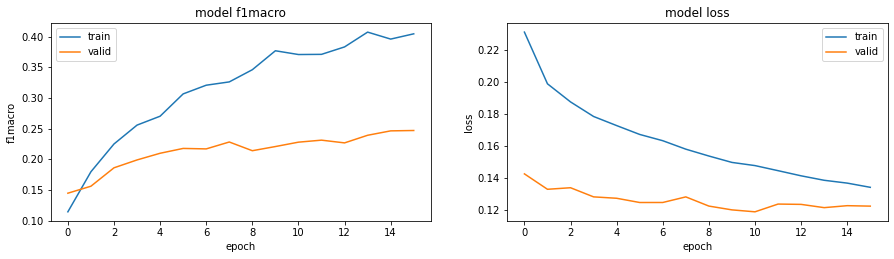

Scoring on test set: [0.11728113144636154, 0.21722659468650818]


In [87]:
train_model(session_prefix='baseline_vs_',
            model_name='InceptionV3',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### EfficientNetB0

In [54]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('EfficientNetB0')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 27s 57ms/step - loss: 0.2671 - f1macro: 0.0421 - val_loss: 0.1727 - val_f1macro: 0.0473

Epoch 00001: val_loss improved from inf to 0.17270, saving model to ./working/final\baseline_vs_EfficientNetB0.h5
Epoch 2/50
316/316 [==============================] - 17s 54ms/step - loss: 0.2440 - f1macro: 0.0501 - val_loss: 0.1700 - val_f1macro: 0.0508

Epoch 00002: val_loss improved from 0.17270 to 0.17004, saving model to ./working/final\baseline_vs_EfficientNetB0.h5
Epoch 3/50
316/316 [

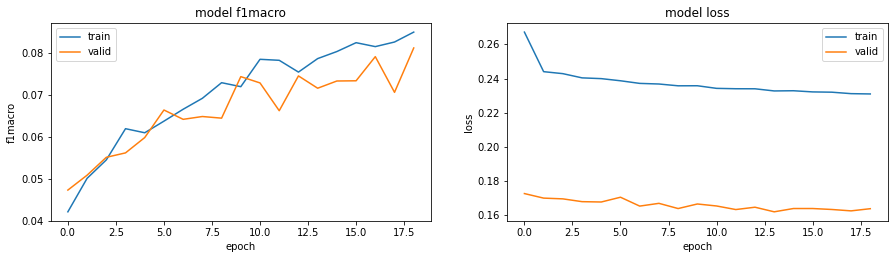

Scoring on test set: [0.16184915602207184, 0.08355477452278137]


In [55]:
train_model(session_prefix='baseline_vs_',
            model_name='EfficientNetB0',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### ResNet50

In [56]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('ResNet50')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 28s 78ms/step - loss: 0.2417 - f1macro: 0.0740 - val_loss: 0.1504 - val_f1macro: 0.0939

Epoch 00001: val_loss improved from inf to 0.15036, saving model to ./working/final\baseline_vs_ResNet50.h5
Epoch 2/50
316/316 [==============================] - 24s 75ms/step - loss: 0.2161 - f1macro: 0.1154 - val_loss: 0.1449 - val_f1macro: 0.1219

Epoch 00002: val_loss improved from 0.15036 to 0.14490, saving model to ./working/final\baseline_vs_ResNet50.h5
Epoch 3/50
316/316 [============

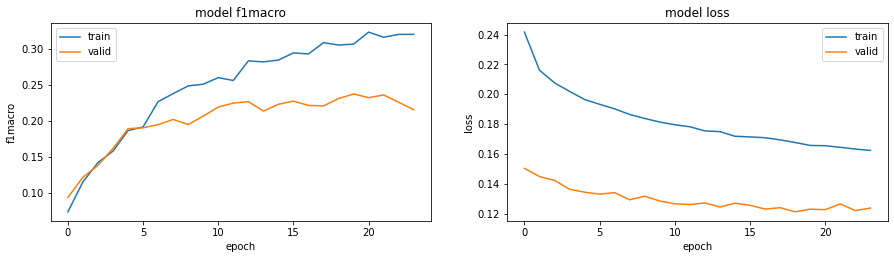

Scoring on test set: [0.1224481612443924, 0.2480429857969284]


In [57]:
train_model(session_prefix='baseline_vs_',
            model_name='ResNet50',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### Result

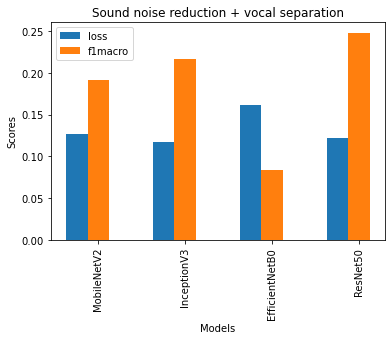

In [13]:
score = {}
loss = {}

score['MobileNetV2'] = 0.1919
score['InceptionV3'] = 0.2172
score['EfficientNetB0'] = 0.0835
score['ResNet50'] = 0.2480

loss['MobileNetV2'] = 0.1263
loss['InceptionV3'] = 0.1172
loss['EfficientNetB0'] = 0.1618
loss['ResNet50'] = 0.1224

ind = np.arange(4)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Sound noise reduction + vocal separation')

plt.xticks(ind + width, ['MobileNetV2', 'InceptionV3',
           'EfficientNetB0', 'ResNet50'], rotation=90)
plt.legend(loc='best')
plt.show()

## Melspectrogram

In [50]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    n_mels = 224
    hop_length = 494
    n_fft = n_mels * 10
    fmin = 20
    fmax = 16000

    # Model parameters
    num_rows = 224
    num_columns = 224
    num_channels = 3

In [51]:
def audio_to_melspectrogram(audio):
    spectrogram = librosa.feature.melspectrogram(audio,
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [52]:
def extractFeatures(model_name, y, sr):
    # Extract features
    feat = audio_to_melspectrogram(y)
    
    # Feed columns with 0 if number of columns < conf.num_columns
    if feat.shape[1] <= conf.num_columns:
        pad_width = conf.num_columns - feat.shape[1]
        feat = np.pad(feat, pad_width=(
            (0, 0), (0, pad_width)), mode='constant')
        
    # 3 channels
    feat = np.stack([feat, feat, feat], axis=-1)
    
    # preprocess
    if model_name == 'MobileNetV2':
        feat = pimnv2(feat)
    elif model_name == 'InceptionV3':
        feat = piv3(feat)
    elif model_name == 'EfficientNetB0':
        feat = penb0(feat)
    elif model_name == 'ResNet50':
        feat = prn50(feat)

    X = np.empty((1, conf.num_rows, conf.num_columns, conf.num_channels))
    x_features = feat.tolist()
    X[0] = np.array(x_features)

    return X

### MobileNetV2

In [62]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('MobileNetV2')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 14s 38ms/step - loss: 0.2007 - f1macro: 0.1600 - val_loss: 0.1118 - val_f1macro: 0.2308

Epoch 00001: val_loss improved from inf to 0.11183, saving model to ./working/final\baseline_ms_MobileNetV2.h5
Epoch 2/50
316/316 [==============================] - 11s 35ms/step - loss: 0.1558 - f1macro: 0.2682 - val_loss: 0.1000 - val_f1macro: 0.2896

Epoch 00002: val_loss improved from 0.11183 to 0.09996, saving model to ./working/final\baseline_ms_MobileNetV2.h5
Epoch 3/50
316/316 [======

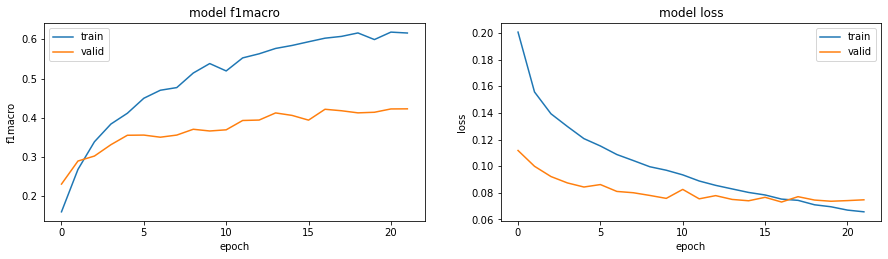

Scoring on test set: [0.07498517632484436, 0.42945143580436707]


In [63]:
train_model(session_prefix='baseline_ms_',
            model_name='MobileNetV2',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### InceptionV3

In [64]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('InceptionV3')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 22s 55ms/step - loss: 0.2183 - f1macro: 0.1469 - val_loss: 0.1301 - val_f1macro: 0.2052

Epoch 00001: val_loss improved from inf to 0.13009, saving model to ./working/final\baseline_ms_InceptionV3.h5
Epoch 2/50
316/316 [==============================] - 17s 53ms/step - loss: 0.1759 - f1macro: 0.2584 - val_loss: 0.1173 - val_f1macro: 0.2483

Epoch 00002: val_loss improved from 0.13009 to 0.11729, saving model to ./working/final\baseline_ms_InceptionV3.h5
Epoch 3/50
316/316 [======

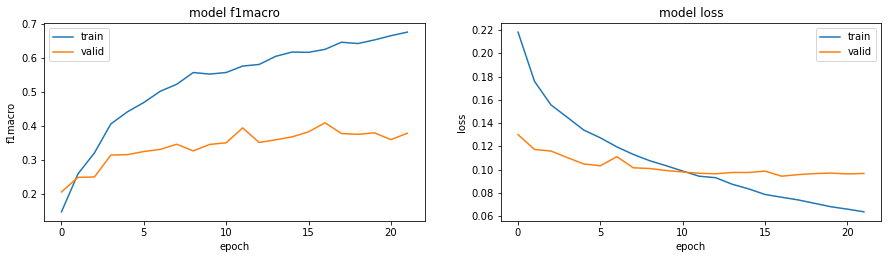

Scoring on test set: [0.0960414707660675, 0.4222085177898407]


In [65]:
train_model(session_prefix='baseline_ms_',
            model_name='InceptionV3',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### EfficientNetB0

In [66]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('EfficientNetB0')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 22s 57ms/step - loss: 0.2057 - f1macro: 0.1402 - val_loss: 0.1116 - val_f1macro: 0.1921

Epoch 00001: val_loss improved from inf to 0.11158, saving model to ./working/final\baseline_ms_EfficientNetB0.h5
Epoch 2/50
316/316 [==============================] - 17s 54ms/step - loss: 0.1616 - f1macro: 0.2256 - val_loss: 0.0985 - val_f1macro: 0.2270

Epoch 00002: val_loss improved from 0.11158 to 0.09851, saving model to ./working/final\baseline_ms_EfficientNetB0.h5
Epoch 3/50
316/316 [

Epoch 30/50
316/316 [==============================] - 17s 54ms/step - loss: 0.0783 - f1macro: 0.5635 - val_loss: 0.0637 - val_f1macro: 0.4611

Epoch 00030: val_loss did not improve from 0.06365

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
Epoch 31/50
316/316 [==============================] - 17s 54ms/step - loss: 0.0769 - f1macro: 0.5832 - val_loss: 0.0638 - val_f1macro: 0.4629

Epoch 00031: val_loss did not improve from 0.06365

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
Epoch 32/50
316/316 [==============================] - 17s 54ms/step - loss: 0.0762 - f1macro: 0.5761 - val_loss: 0.0633 - val_f1macro: 0.4307

Epoch 00032: val_loss improved from 0.06365 to 0.06330, saving model to ./working/final\baseline_ms_EfficientNetB0.h5
Epoch 33/50
316/316 [==============================] - 17s 54ms/step - loss: 0.0760 - f1macro: 0.5963 - val_loss: 0.0632 - val_f1macro: 0.4485

Epoch 00033: val_loss improved from 0.063

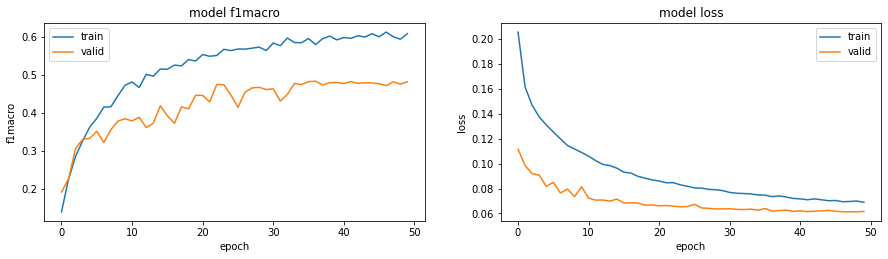

Scoring on test set: [0.0600016713142395, 0.490891695022583]


In [67]:
train_model(session_prefix='baseline_ms_',
            model_name='EfficientNetB0',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### ResNet50

In [68]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('ResNet50')

IntProgress(value=0, max=14080)

Class weights
{0: 3.1419637033987953, 1: 3.669718389265234, 2: 1.063421846889857, 3: 3.079225362765372, 4: 5.243224292473271, 5: 2.9406391994792256, 6: 5.51148827906795, 7: 1.684520523136885, 8: 2.173804303128121, 9: 4.338768018246119, 10: 4.362865569825179, 11: 4.985395183171171, 12: 1, 13: 1.2640925423520082, 14: 1.5514079786860249, 15: 4.550077111913326, 16: 1.9301083788605897, 17: 5.879213059193268, 18: 1, 19: 1.3671332962711884, 20: 2.218504482046028}

Epoch 1/50
316/316 [==============================] - 27s 77ms/step - loss: 0.1831 - f1macro: 0.2093 - val_loss: 0.0963 - val_f1macro: 0.2755

Epoch 00001: val_loss improved from inf to 0.09630, saving model to ./working/final\baseline_ms_ResNet50.h5
Epoch 2/50
316/316 [==============================] - 24s 75ms/step - loss: 0.1306 - f1macro: 0.3601 - val_loss: 0.0863 - val_f1macro: 0.3678

Epoch 00002: val_loss improved from 0.09630 to 0.08626, saving model to ./working/final\baseline_ms_ResNet50.h5
Epoch 3/50
316/316 [============

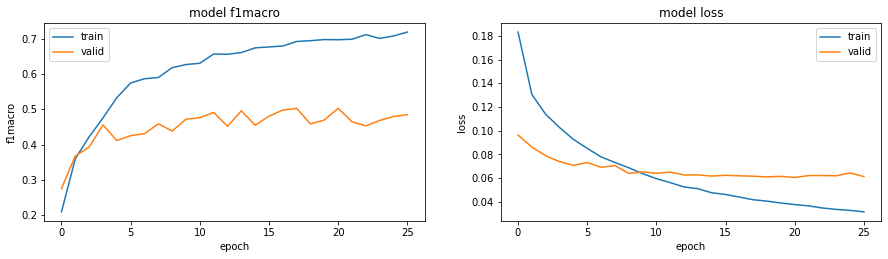

Scoring on test set: [0.0582747720181942, 0.45507511496543884]


In [69]:
train_model(session_prefix='baseline_ms_',
            model_name='ResNet50',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

### Result

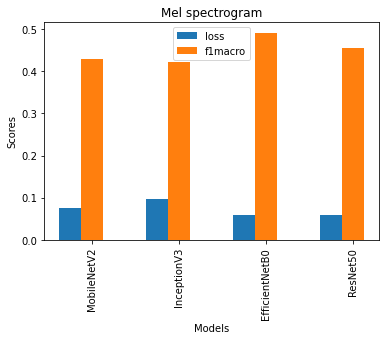

In [14]:
score = {}
loss = {}

score['MobileNetV2'] = 0.4294
score['InceptionV3'] = 0.4222
score['EfficientNetB0'] = 0.4908
score['ResNet50'] = 0.4550

loss['MobileNetV2'] = 0.0749
loss['InceptionV3'] = 0.0960
loss['EfficientNetB0'] = 0.0600
loss['ResNet50'] = 0.0582

ind = np.arange(4)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Mel spectrogram')

plt.xticks(ind + width, ['MobileNetV2', 'InceptionV3',
           'EfficientNetB0', 'ResNet50'], rotation=90)
plt.legend(loc='best')
plt.show()

# Data augmentation

## Functions

In [53]:
# stretching the sound
def stretch(data, rate=1):
    input_length = len(data)
    data = librosa.effects.time_stretch(data, rate)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

    return data

In [54]:
def collect_data(row, data, path, new):
    if new:
        data.append([row['primary_label'], 
                     row['secondary_labels'], 
                     row['original_filename'],
                     path,
                     row['target']
                    ])
    else:
        data.append([row['primary_label'], 
                     row['secondary_labels'], 
                     row['original_filename'],
                     row['filename'],
                     row['target']
                    ])
    
    return data

In [55]:
def augmentTrainAudio(_df):
    # Instantiate the progress bar
    max_count = _df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    data = []
    for index, row in _df.iterrows():
        # Increment the progress bar
        f.value += 1
        
        data = collect_data(row, data, None, False)

        # Get file path
        file_path = row['filename']

        # Load audio
        audio, sr = librosa.load(file_path)

        # Adding white noise
        wn = np.random.randn(len(audio))
        audio_wn = audio + 0.005*wn
        wn_file_path = file_path.replace('.ogg', '.wn.wav')
        sf.write(wn_file_path, audio_wn, sr, 'PCM_24')
        data = collect_data(row, data, wn_file_path, True)

        # Shifting the sound
        audio_roll = np.roll(audio, sr*3)
        roll_file_path = file_path.replace('.ogg', '.roll.wav')
        sf.write(roll_file_path, audio_roll, sr, 'PCM_24')
        data = collect_data(row, data, roll_file_path, True)

        # stretching the sound
        audio_st = stretch(audio, 0.80)
        st_file_path = file_path.replace('.ogg', '.st.wav')
        sf.write(st_file_path, audio_st, sr, 'PCM_24')
        data = collect_data(row, data, st_file_path, True)

    data_df = pd.DataFrame(data, columns=['primary_label', 'secondary_labels', 'original_filename',
                                          'filename', 'target'])
    data_df.to_pickle(WORKING_PATH + 'data_augmented_df.pkl')

In [56]:
if not os.path.exists(WORKING_PATH + 'data_augmented_df.pkl'):
    # If not already done, augment data
    augmentTrainAudio(data_df)
    
    # Load split result
    data_df = pd.read_pickle(WORKING_PATH + 'data_augmented_df.pkl')
    
else:
    # If split done, load split result
    data_df = pd.read_pickle(WORKING_PATH + 'data_augmented_df.pkl')

## EfficientNetB0

In [57]:
# Load data in RAM to speed up training process
data_mem = LoadRAM('EfficientNetB0')

IntProgress(value=0, max=56320)

In [58]:
# Split data
X_train, X_test, _, _ = train_test_split(
    data_df, data_df['target'], test_size=0.1, random_state=42)
X_train, X_valid, _, _ = train_test_split(
    X_train, X_train['target'], test_size=0.2, random_state=42)

# Instanciate data generators
train_generator = DataGenerator(X_train, **params_train)
valid_generator = DataGenerator(X_valid, **params_valid)
test_generator = DataGenerator(X_test, **params_valid)

Class weights
{0: 3.1081275724908664, 1: 3.7656475754076606, 2: 1.0441328733521613, 3: 3.0691726047550407, 4: 5.264737430672896, 5: 2.8777563180552033, 6: 5.46209686483139, 7: 1.69247564674142, 8: 2.124710995914189, 9: 4.432477447650233, 10: 4.419574042814324, 11: 4.854309533222602, 12: 1, 13: 1.2511821233781157, 14: 1.5747391996382374, 15: 4.445549529217585, 16: 1.91982088490933, 17: 6.173593184059532, 18: 1, 19: 1.3683585469443174, 20: 2.205399907164332}

Epoch 1/50
1267/1267 [==============================] - 276s 207ms/step - loss: 0.1799 - f1macro: 0.2006 - val_loss: 0.0994 - val_f1macro: 0.2934

Epoch 00001: val_loss improved from inf to 0.09938, saving model to ./working/final\baseline_ms_da_EfficientNetB0.h5
Epoch 2/50
1267/1267 [==============================] - 314s 248ms/step - loss: 0.1434 - f1macro: 0.3321 - val_loss: 0.0916 - val_f1macro: 0.3466

Epoch 00002: val_loss improved from 0.09938 to 0.09162, saving model to ./working/final\baseline_ms_da_EfficientNetB0.h5
Epoch 

Epoch 29/50
1267/1267 [==============================] - 216s 170ms/step - loss: 0.0758 - f1macro: 0.5949 - val_loss: 0.0590 - val_f1macro: 0.5778

Epoch 00029: val_loss improved from 0.05987 to 0.05898, saving model to ./working/final\baseline_ms_da_EfficientNetB0.h5
Epoch 30/50
1267/1267 [==============================] - 216s 170ms/step - loss: 0.0752 - f1macro: 0.6069 - val_loss: 0.0593 - val_f1macro: 0.5818

Epoch 00030: val_loss did not improve from 0.05898

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00022876793809700757.
Epoch 31/50
1267/1267 [==============================] - 211s 166ms/step - loss: 0.0752 - f1macro: 0.6070 - val_loss: 0.0590 - val_f1macro: 0.5881

Epoch 00031: val_loss improved from 0.05898 to 0.05895, saving model to ./working/final\baseline_ms_da_EfficientNetB0.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00020589114428730683.
Epoch 32/50
1267/1267 [==============================] - 209s 165ms/step - loss: 0.0741 - f1macro: 

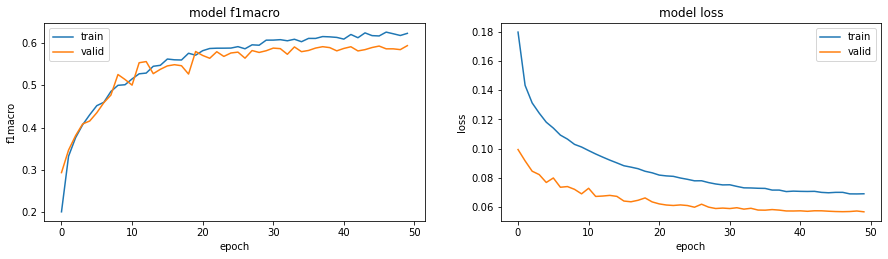

Scoring on test set: [0.05693114921450615, 0.5984118580818176]


In [59]:
train_model(session_prefix='baseline_ms_da_',
            model_name='EfficientNetB0',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

## Fine tune

Class weights
{0: 3.1081275724908664, 1: 3.7656475754076606, 2: 1.0441328733521613, 3: 3.0691726047550407, 4: 5.264737430672896, 5: 2.8777563180552033, 6: 5.46209686483139, 7: 1.69247564674142, 8: 2.124710995914189, 9: 4.432477447650233, 10: 4.419574042814324, 11: 4.854309533222602, 12: 1, 13: 1.2511821233781157, 14: 1.5747391996382374, 15: 4.445549529217585, 16: 1.91982088490933, 17: 6.173593184059532, 18: 1, 19: 1.3683585469443174, 20: 2.205399907164332}

Epoch 1/50
1267/1267 [==============================] - 251s 192ms/step - loss: 0.1615 - f1macro: 0.3760 - val_loss: 0.0704 - val_f1macro: 0.4758

Epoch 00001: val_loss improved from inf to 0.07041, saving model to ./working/final\finetune_ms_da_EfficientNetB0.h5
Epoch 2/50
1267/1267 [==============================] - 230s 181ms/step - loss: 0.0918 - f1macro: 0.5050 - val_loss: 0.0576 - val_f1macro: 0.5557

Epoch 00002: val_loss improved from 0.07041 to 0.05759, saving model to ./working/final\finetune_ms_da_EfficientNetB0.h5
Epoch 

1267/1267 [==============================] - 225s 178ms/step - loss: 0.0112 - f1macro: 0.7458 - val_loss: 0.0253 - val_f1macro: 0.7106

Epoch 00029: val_loss improved from 0.02564 to 0.02534, saving model to ./working/final\finetune_ms_da_EfficientNetB0.h5
Epoch 30/50
1267/1267 [==============================] - 218s 172ms/step - loss: 0.0107 - f1macro: 0.7556 - val_loss: 0.0260 - val_f1macro: 0.7161

Epoch 00030: val_loss did not improve from 0.02534

Epoch 00030: ReduceLROnPlateau reducing learning rate to 3.138105967082083e-05.
Epoch 31/50
1267/1267 [==============================] - 208s 164ms/step - loss: 0.0106 - f1macro: 0.7535 - val_loss: 0.0260 - val_f1macro: 0.6986

Epoch 00031: val_loss did not improve from 0.02534

Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.824295370373875e-05.
Epoch 32/50
1267/1267 [==============================] - 200s 158ms/step - loss: 0.0099 - f1macro: 0.7428 - val_loss: 0.0261 - val_f1macro: 0.7029

Epoch 00032: val_loss did not impro

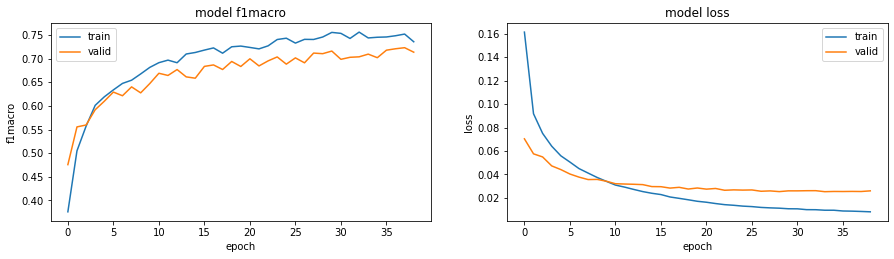

Scoring on test set: [0.025258608162403107, 0.6997257471084595]


In [60]:
train_model(session_prefix='finetune_ms_da_',
            model_name='EfficientNetB0',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=207,
            model_path=WORKING_PATH + 'baseline_ms_da_EfficientNetB0.h5',
            learning_rate=1e-4,
            epochs=50,
            cw_method='log',
            mu=0.25,
            hidden=142
            )

## Results

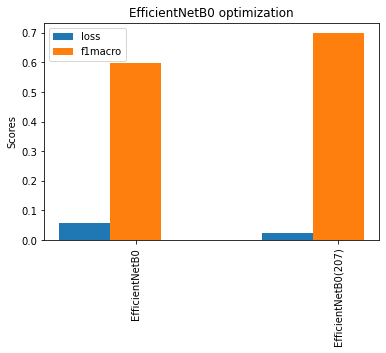

In [7]:
score = {}
loss = {}

score['EfficientNetB0'] = 0.5984
score['EfficientNetB0(207)'] = 0.6997

loss['EfficientNetB0'] = 0.0569
loss['EfficientNetB0(207)'] = 0.0252

ind = np.arange(2)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.ylabel('Scores')
plt.title('EfficientNetB0 optimization')

plt.xticks(ind + width, ['EfficientNetB0', 'EfficientNetB0(207)'], rotation=90)
plt.legend(loc='best')
plt.show()

# VGGish

## Preprocessing

In [62]:
def extractFeatures(y, sr):
    feat = vggish_input.waveform_to_examples(y, sr)
        
    return feat

## Data generator

In [63]:
class DataGenerator(Sequence):
    def __init__(self,
                 _X,
                 batch_size=32,
                 n_channels=1,
                 n_columns=470,
                 n_rows=120,
                 shuffle=True):
        self.batch_size = batch_size
        self.X = _X
        self.n_channels = n_channels
        self.n_columns = n_columns
        self.n_rows = n_rows
        self.shuffle = shuffle
        self.img_indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temps)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temps):
        X = np.empty((self.batch_size, self.n_rows, self.n_columns, self.n_channels))
        y = np.empty((self.batch_size, len(mlb.classes_)), dtype=int)
        for i, ID in enumerate(list_IDs_temps):
            file_path = self.X.iloc[ID]['filename']
            
            #audio, sr = librosa.load(file_path)
            #feat = extractFeatures(audio, sr)
            
            feat = data_mem[file_path]
            
            x_features = feat.tolist()
            label = self.X.iloc[ID]['target']
            X[i] = np.array(x_features)
            y[i] = mlb.transform([label])
        X = X.reshape(X.shape[0], self.n_rows, self.n_columns, self.n_channels)
        
        return X, y

In [64]:
def LoadRAM():
    # Load extracted features into RAM
    data_mem.clear()

    # Instantiate the progress bar
    max_count = data_df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    temp = {}

    for index, row in data_df.iterrows():
        # Increment the progress bar
        f.value += 1

        # Get file path
        file_path = row['filename']
        # Load audio file
        audio, sr = librosa.load(file_path)
        # Extracxt features
        feat = extractFeatures(audio, sr)

        # Store features into the dedicated dictionary
        temp[row['filename']] = feat

    return temp

## Model

In [65]:
def create_vggish(fine_tune_at=None,
                  model_path=None
                  ):

    # Instanciate model
    base_model, _, _ = vgk.get_embedding_model(hop_duration=0.25)
    dense = Dense(128, activation='relu')(base_model.output)
    outputs = Dense(len(mlb.classes_), activation='sigmoid')(dense)

    base_model.trainable = True

    if fine_tune_at == None:
        model = Model(inputs=base_model.input, outputs=outputs)

    else:
        model = Model(inputs=base_model.input, outputs=outputs)

        # Load existing weights
        model.load_weights(model_path)

        # Unfreeze model layers
        model.trainable = True

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = False

    return model

## Training

In [66]:
params = dict(
    batch_size=32,
    n_rows=5,
    n_columns=96,
    n_channels=64,
)
params_train = dict(
    shuffle=True,
    **params
)
params_valid = dict(
    shuffle=False,
    **params
)

In [67]:
# Split data
X_train, X_test, _, _ = train_test_split(
    data_df, data_df['target'], test_size=0.1, random_state=42)
X_train, X_valid, _, _ = train_test_split(
    X_train, X_train['target'], test_size=0.2, random_state=42)

# Instanciate data generators
train_generator = DataGenerator(X_train, **params_train)
valid_generator = DataGenerator(X_valid, **params_valid)
test_generator = DataGenerator(X_test, **params_valid)

In [68]:
def train_model(session_prefix,
                model_name,
                train_gen,
                val_gen,
                test_gen,
                fine_tune_at,
                model_path,
                learning_rate,
                epochs,
                cw_method,
                mu
                ):

    # Define checkpoint_model_path
    checkpoint_model_path = WORKING_PATH + session_prefix + model_name + '.h5'

    num_epochs = epochs
    metric = 'val_loss'

    # Callbacks
    checkpointer = ModelCheckpoint(filepath=checkpoint_model_path,
                                   monitor=metric,
                                   mode='min',
                                   verbose=1,
                                   save_best_only=True)

    es_callback = EarlyStopping(monitor=metric,
                                mode='min',
                                patience=5,
                                verbose=1,
                                restore_best_weights=True
                                )

    reduce_lr = ReduceLROnPlateau(monitor=metric,
                                  factor=0.9,
                                  mode='min',
                                  patience=1,
                                  verbose=1,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=0.00001)

    # Class weights
    class_weights = class_weight(method=cw_method, generator=train_gen, mu=mu)
    print('Class weights')
    print(class_weights)
    print('')

    # Model
    model = create_vggish(fine_tune_at, model_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(mlb.classes_), average='macro')])

    # Fit
    history = model.fit(
        train_gen,
        epochs=num_epochs,
        validation_data=val_gen,
        callbacks=[checkpointer, es_callback, reduce_lr],
        verbose=1,
        class_weight=class_weights
    )

    # Graph
    plot_his(history)

    # Scoring
    evaluation = model.evaluate_generator(test_gen)
    print('Scoring on test set:', evaluation)

In [69]:
# Load data in RAM to speed up training process
data_mem = LoadRAM()

IntProgress(value=0, max=56320)

Class weights
{0: 3.1081275724908664, 1: 3.7656475754076606, 2: 1.0441328733521613, 3: 3.0691726047550407, 4: 5.264737430672896, 5: 2.8777563180552033, 6: 5.46209686483139, 7: 1.69247564674142, 8: 2.124710995914189, 9: 4.432477447650233, 10: 4.419574042814324, 11: 4.854309533222602, 12: 1, 13: 1.2511821233781157, 14: 1.5747391996382374, 15: 4.445549529217585, 16: 1.91982088490933, 17: 6.173593184059532, 18: 1, 19: 1.3683585469443174, 20: 2.205399907164332}

Epoch 1/50
1267/1267 [==============================] - 280s 219ms/step - loss: 0.2264 - f1macro: 0.0949 - val_loss: 0.1219 - val_f1macro: 0.1572 - ETA: 30s -  - ETA: 12s - los - ETA: 9s - loss: 0.2283 - f1macro: 0.09 - ETA:  - ETA: 2s - loss: 0.2271 

Epoch 00001: val_loss improved from inf to 0.12192, saving model to ./working/final\baseline_da_VGGish.h5
Epoch 2/50
1267/1267 [==============================] - 213s 168ms/step - loss: 0.1674 - f1macro: 0.2024 - val_loss: 0.1113 - val_f1macro: 0.2182

Epoch 00002: val_loss improved f

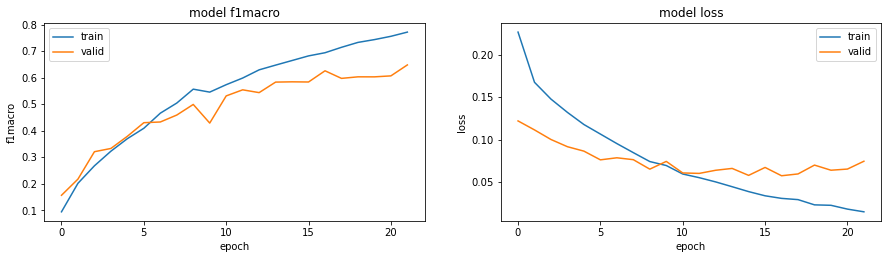

Scoring on test set: [0.05522502586245537, 0.6256366968154907]


In [70]:
train_model(session_prefix='baseline_da_',
            model_name='VGGish',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25
            )

## Fine tune

Class weights
{0: 3.1081275724908664, 1: 3.7656475754076606, 2: 1.0441328733521613, 3: 3.0691726047550407, 4: 5.264737430672896, 5: 2.8777563180552033, 6: 5.46209686483139, 7: 1.69247564674142, 8: 2.124710995914189, 9: 4.432477447650233, 10: 4.419574042814324, 11: 4.854309533222602, 12: 1, 13: 1.2511821233781157, 14: 1.5747391996382374, 15: 4.445549529217585, 16: 1.91982088490933, 17: 6.173593184059532, 18: 1, 19: 1.3683585469443174, 20: 2.205399907164332}

Epoch 1/50
1267/1267 [==============================] - 220s 173ms/step - loss: 0.0198 - f1macro: 0.7468 - val_loss: 0.0578 - val_f1macro: 0.6271

Epoch 00001: val_loss improved from inf to 0.05778, saving model to ./working/final\finetune_da_VGGish.h5
Epoch 2/50
1267/1267 [==============================] - 214s 169ms/step - loss: 0.0161 - f1macro: 0.7676 - val_loss: 0.0618 - val_f1macro: 0.6483 - ETA: 4s - 

Epoch 00002: val_loss did not improve from 0.05778

Epoch 00002: ReduceLROnPlateau reducing learning rate to 8.99999977264087

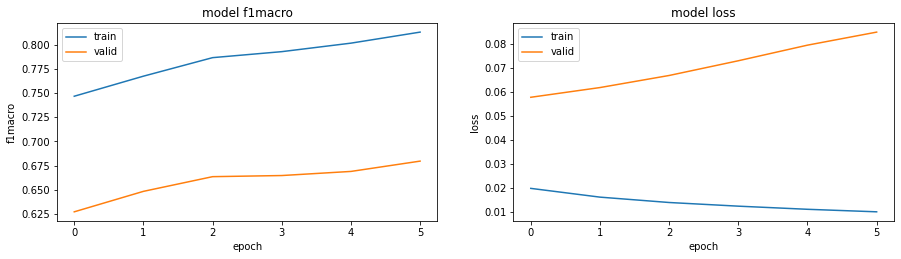

Scoring on test set: [0.05298694223165512, 0.647951602935791]


In [72]:
train_model(session_prefix='finetune_da_',
            model_name='VGGish',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=0,
            model_path=WORKING_PATH + 'baseline_da_VGGish.h5',
            learning_rate=1e-4,
            epochs=50,
            cw_method='log',
            mu=0.25
            )

## Results

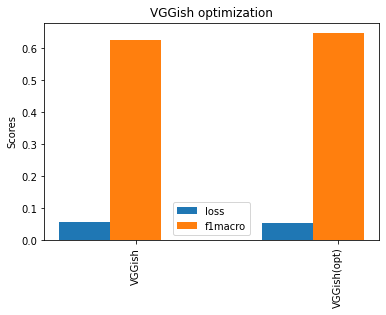

In [8]:
score = {}
loss = {}

score['VGGish'] = 0.6256
score['VGGish(opt)'] = 0.6479

loss['VGGish'] = 0.0552
loss['VGGish(opt)'] = 0.0529

ind = np.arange(2)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.ylabel('Scores')
plt.title('VGGish optimization')

plt.xticks(ind + width, ['VGGish', 'VGGish(opt)'], rotation=90)
plt.legend(loc='best')
plt.show()

# TRILL

## Preprocessing

In [57]:
# Sound noise reduction
def f_high(y, sr):
    b, a = signal.butter(10, 1000/(sr/2), btype='highpass')
    yf = signal.lfilter(b, a, y)
    return yf

In [58]:
def extractFeatures(y, sr):
    # Sound noise reduction
    y = f_high(y, sr)
    # Resample
    y = librosa.resample(y, sr, 16000)

    return y

## Data generator

In [59]:
class DataGenerator(Sequence):
    def __init__(self,
                 _X,
                 batch_size=32,
                 n_channels=1,
                 n_columns=470,
                 n_rows=120,
                 shuffle=True):
        self.batch_size = batch_size
        self.X = _X
        self.n_channels = n_channels
        self.n_columns = n_columns
        self.n_rows = n_rows
        self.shuffle = shuffle
        self.img_indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temps)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temps):
        X = np.empty((self.batch_size, 80000))
        y = np.empty((self.batch_size, len(mlb.classes_)), dtype=int)
        for i, ID in enumerate(list_IDs_temps):
            file_path = self.X.iloc[ID]['filename']

            #audio, sr = librosa.load(file_path)
            #feat = extractFeatures(audio, sr)

            feat = data_mem[file_path]

            x_features = feat.tolist()
            label = self.X.iloc[ID]['target']
            X[i] = np.array(x_features)
            y[i] = mlb.transform([label])

        return X, y

In [60]:
def LoadRAM():
    # Load extracted features into RAM
    data_mem.clear()

    # Instantiate the progress bar
    max_count = data_df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    temp = {}

    for index, row in data_df.iterrows():
        # Increment the progress bar
        f.value += 1

        # Get file path
        file_path = row['filename']
        # Load audio file
        audio, sr = librosa.load(file_path)
        # Extracxt features
        feat = extractFeatures(audio, sr)

        # Store features into the dedicated dictionary
        temp[row['filename']] = feat

    return temp

## Model

In [61]:
def get_keras_model(num_classes, input_length, use_batchnorm=True, l2=1e-5,
                    num_clusters=None, trainable=True, pooling='avg', hidden=0):
    """Make a model."""
    model = tf2.keras.models.Sequential()
    
    model.add(tf2.keras.Input((input_length,)))
    
    # 'https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3'
    trill_layer = hub.KerasLayer(
        handle=WORKING_PATH + 'trill/',
        trainable=trainable,
        arguments={'sample_rate': int(16000)},
        output_key='embedding',
        output_shape=[None, 2048]
    )
    
    model.add(trill_layer)
    
    if num_clusters and num_clusters > 0:
        model.add(NetVLAD(num_clusters=num_clusters))
        if use_batchnorm:
            model.add(tf2.keras.layers.BatchNormalization())
    else:
        if pooling == 'avg':
            # Average pooling
            model.add(tf2.keras.layers.GlobalAveragePooling1D())  
        else:
            model.add(tf2.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)))
       
    # Hidden layer
    if hidden != 0:
        model.add(tf2.keras.layers.Dense(
            hidden, 
            activation='relu'))
    
    # Fully connected
    model.add(tf2.keras.layers.Dense(
        num_classes, 
        activation='sigmoid',
        kernel_regularizer=tf2.keras.regularizers.l2(l=l2)))

    return model

In [70]:
def create_trill(num_clusters, use_batchnorm, pooling, hidden, fine_tune_at, model_path):
    if fine_tune_at == None:
        print('fine_tune_at == None')
        model = get_keras_model(len(mlb.classes_), 
                                80000, 
                                use_batchnorm=use_batchnorm, 
                                l2=1e-5,
                                num_clusters=num_clusters, 
                                trainable=False,
                                pooling=pooling,
                                hidden=hidden
                               )

    else:
        print('model.load_weights')
        model = get_keras_model(len(mlb.classes_), 
                                80000, 
                                use_batchnorm=use_batchnorm, 
                                l2=1e-5,
                                num_clusters=num_clusters, 
                                trainable=True,
                                pooling=pooling,
                                hidden=hidden
                               )

        # Load existing weights
        model.load_weights(model_path)

    print('')
    model.summary()
    print('')
    
    return model

## Training

In [63]:
params = dict(
    batch_size=32,
    n_rows=224,
    n_columns=216,
    n_channels=3,
)
params_train = dict(
    shuffle=False,
    **params
)
params_valid = dict(
    shuffle=False,
    **params
)

In [64]:
# Split data
X_train, X_test, _, _ = train_test_split(
    data_df, data_df['target'], test_size=0.1, random_state=42)
X_train, X_valid, _, _ = train_test_split(
    X_train, X_train['target'], test_size=0.2, random_state=42)

# Instanciate data generators
train_generator = DataGenerator(X_train, **params_train)
valid_generator = DataGenerator(X_valid, **params_valid)
test_generator = DataGenerator(X_test, **params_valid)

In [65]:
def train_model(session_prefix,
                model_name,
                train_gen,
                val_gen,
                test_gen,
                fine_tune_at,
                model_path,
                learning_rate,
                epochs,
                cw_method,
                mu
                ):

    # Define checkpoint_model_path
    checkpoint_model_path = WORKING_PATH + session_prefix + model_name + '.h5'

    num_epochs = epochs
    metric = 'val_loss'

    # Callbacks
    checkpointer = ModelCheckpoint(filepath=checkpoint_model_path,
                                   monitor=metric,
                                   mode='min',
                                   verbose=1,
                                   save_best_only=True)

    es_callback = EarlyStopping(monitor=metric,
                                mode='min',
                                patience=5,
                                verbose=1,
                                restore_best_weights=True
                                )

    reduce_lr = ReduceLROnPlateau(monitor=metric,
                                  factor=0.9,
                                  mode='min',
                                  patience=1,
                                  verbose=1,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=0.00001)

    # Class weights
    class_weights = class_weight(method=cw_method, generator=train_gen, mu=mu)
    print('Class weights')
    print(class_weights)
    print('')

    # Model
    model = create_trill(num_clusters=8, 
                         use_batchnorm=True,
                         pooling=None, 
                         hidden=256,
                         fine_tune_at=fine_tune_at, 
                         model_path=model_path)
    model.compile(optimizer=tf2.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(mlb.classes_), average='macro')])

    # Fit
    history = model.fit(
        train_gen,
        epochs=num_epochs,
        validation_data=val_gen,
        callbacks=[checkpointer, es_callback, reduce_lr],
        verbose=1,
        class_weight=class_weights
    )

    # Graph
    plot_his(history)

    # Scoring
    evaluation = model.evaluate_generator(test_gen)
    print('Scoring on test set:', evaluation)

In [66]:
# Load data in RAM to speed up training process
data_mem = LoadRAM()

IntProgress(value=0, max=56320)

Class weights
{0: 3.1081275724908664, 1: 3.7656475754076606, 2: 1.0441328733521613, 3: 3.0691726047550407, 4: 5.264737430672896, 5: 2.8777563180552033, 6: 5.46209686483139, 7: 1.69247564674142, 8: 2.124710995914189, 9: 4.432477447650233, 10: 4.419574042814324, 11: 4.854309533222602, 12: 1, 13: 1.2511821233781157, 14: 1.5747391996382374, 15: 4.445549529217585, 16: 1.91982088490933, 17: 6.173593184059532, 18: 1, 19: 1.3683585469443174, 20: 2.205399907164332}

fine_tune_at == None

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, None, 2048)        51964864  
_________________________________________________________________
net_vlad (NetVLAD)           (None, 16384)             32776     
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
________________________________

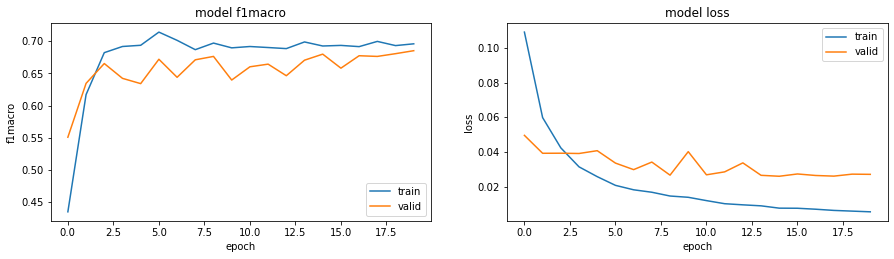

Scoring on test set: [0.02558259479701519, 0.6930050849914551]


In [69]:
train_model(session_prefix='baseline_da_',
            model_name='Trill',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=None,
            model_path=None,
            learning_rate=1e-3,
            epochs=50,
            cw_method='log',
            mu=0.25
            )

## Fine tune

Class weights
{0: 3.1081275724908664, 1: 3.7656475754076606, 2: 1.0441328733521613, 3: 3.0691726047550407, 4: 5.264737430672896, 5: 2.8777563180552033, 6: 5.46209686483139, 7: 1.69247564674142, 8: 2.124710995914189, 9: 4.432477447650233, 10: 4.419574042814324, 11: 4.854309533222602, 12: 1, 13: 1.2511821233781157, 14: 1.5747391996382374, 15: 4.445549529217585, 16: 1.91982088490933, 17: 6.173593184059532, 18: 1, 19: 1.3683585469443174, 20: 2.205399907164332}

model.load_weights

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, None, 2048)        51964864  
_________________________________________________________________
net_vlad_2 (NetVLAD)         (None, 16384)             32776     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16384)             65536     
__________________________________

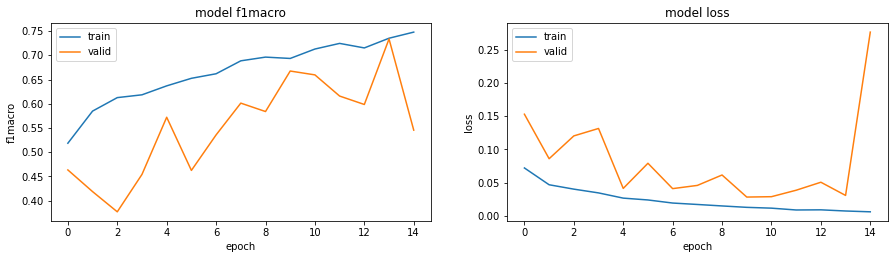

Scoring on test set: [0.02346270904481411, 0.7087979780006409]


In [71]:
train_model(session_prefix='finetune_da_',
            model_name='Trill',
            train_gen=train_generator,
            val_gen=valid_generator,
            test_gen=test_generator,
            fine_tune_at=0,
            model_path=WORKING_PATH + 'baseline_da_Trill.h5',
            learning_rate=1e-4,
            epochs=50,
            cw_method='log',
            mu=0.25
            )

## Results

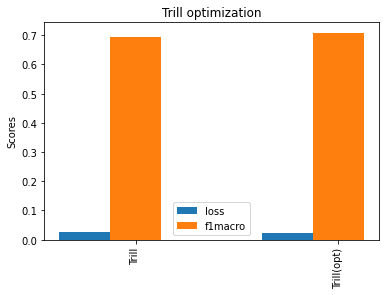

In [2]:
score = {}
loss = {}

score['Trill'] = 0.6930
score['Trill(opt)'] = 0.7087

loss['Trill'] = 0.0255
loss['Trill(opt)'] = 0.0234

ind = np.arange(2)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.ylabel('Scores')
plt.title('Trill optimization')

plt.xticks(ind + width, ['Trill', 'Trill(opt)'], rotation=90)
plt.legend(loc='best')
plt.show()

# Final chosen model

With a final score of 0.7087 on the test set, Trill get the most important score and is selected for a competiton submission.

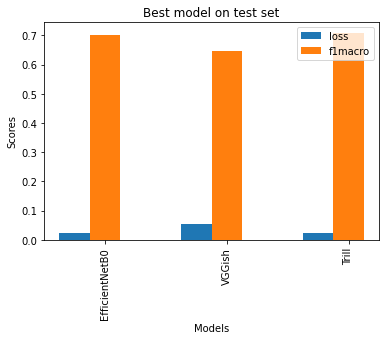

In [3]:
score = {}
loss = {}

score['EfficientNetB0'] = 0.6997
score['VGGish'] = 0.6479
score['Trill'] = 0.7087

loss['EfficientNetB0'] = 0.0252
loss['VGGish'] = 0.0529
loss['Trill'] = 0.0234

ind = np.arange(3)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Best model on test set')

plt.xticks(ind + width, ['EfficientNetB0', 'VGGish', 'Trill'], rotation=90)
plt.legend(loc='best')
plt.show()

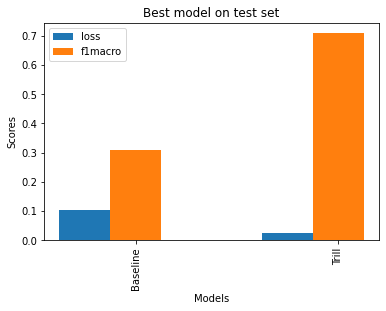

In [2]:
score = {}
loss = {}

score['Baseline'] = 0.3079
score['Trill'] = 0.7087

loss['Baseline'] = 0.1039
loss['Trill'] = 0.0234

ind = np.arange(2)
width = 0.25
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='f1macro')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Best model on test set')

plt.xticks(ind + width, ['Baseline', 'Trill'], rotation=90)
plt.legend(loc='best')
plt.show()